The aim here is to compare the recovery (in terms of average summed synapse strength onto excitatory cells and firing rate distributions of excitatory cells) of a network of HVC RA-projectors and interneurons following a 50% perturbation of the RA-projectors.

Here, we compare the recovery under 3 distinct sets of plasticity rules:

1. burst timing-dependent plasticity + single-cell firing rate upper bound + population-level firing rate rule
2. burst timing-dependent plasticity + single-cell firing rate (asym about setpoint)
3. burst timing-dependent plasticity + population-level firing rate rule

In [31]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import stats
import scipy.io as sio
import pandas as pd
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os
from scipy.ndimage.interpolation import shift
from functools import reduce
import time

from aux import Generic, bin_occurrences
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG
from utils.general import *
from utils.file_io import *

dt = 0.2e-3

In [32]:
def save_fig(fig, path, name):
    if not os.path.exists(path):
        os.makedirs(path)
    fig.savefig(os.path.join(path, name))

In [33]:
def get_equally_spaced_colors(n, cmap='autumn'):
    cmap = plt.get_cmap(cmap)
    colors = cmap(np.linspace(0, 1, n))
    return [matplotlib.colors.rgb2hex(rgba) for rgba in colors]

In [34]:
def process_single_activation(exc_raster, n):
    # extract first spikes
    first_spk_times = np.nan * np.ones(n)
    for i in range(exc_raster.shape[1]):
        nrn_idx = int(exc_raster[1, i])
        if np.isnan(first_spk_times[nrn_idx]):
            first_spk_times[nrn_idx] = exc_raster[0, i]
    return first_spk_times

In [35]:
def load_exp_data(direc, cut=None, layer_size=10, name_frags=[]):
    file_names = [f for f in sorted(all_files_from_dir(direc))]
    file_names = [f for f in filter_list_by_name_frags(file_names, name_frags)]
    if cut is not None:
        file_names = file_names[:cut]
    
    for i_f in range(0, len(file_names)):
        file = file_names[i_f]
        loaded = sio.loadmat(os.path.join(direc, file))
        
        summed_incoming_weights = loaded['w_r_e_summed']
        if len(summed_incoming_weights.shape) > 1:
            shape = summed_incoming_weights.shape
            summed_incoming_weights = summed_incoming_weights.reshape(shape[0] * shape[1])
        
        try:
            exc_cells_initially_active = loaded['exc_raster']
            exc_cells_newly_active = None
        except KeyError as e:
            exc_cells_initially_active = loaded['exc_cells_initially_active'].astype(float)
            exc_cells_newly_active = loaded['exc_cells_newly_active'].astype(float)
            exc_cells_initially_active[0, :] = exc_cells_initially_active[0, :] * dt
            if exc_cells_newly_active is not None and exc_cells_newly_active.shape[0] > 0:
                exc_cells_newly_active[0, :] = exc_cells_newly_active[0, :] * dt
        inh_raster = loaded['inh_raster']
        
        try:
            surviving_cell_indices = loaded['surviving_cell_indices'][0].astype(bool)
        except KeyError as e:
            
            surviving_cell_indices = np.ones(summed_incoming_weights.shape[0], dtype=bool)
        
        first_spk_times = process_single_activation(exc_cells_initially_active, 900)
        
        last_layer_active = 0
        layer_weights = []
        
        for i in range(0, len(first_spk_times), layer_size):
            layer_active = np.any(~np.isnan(first_spk_times[i:i+layer_size]))
            if layer_active:
                last_layer_active = i/layer_size
        
            layer_weight = np.sum(summed_incoming_weights[i:(i + layer_size)])
            layer_weights.append(layer_weight)
            
        data = {
            'index': i_f,
            'last_layer_active': last_layer_active,
            'first_spk_times': first_spk_times,
            'mean_incoming_summed_weights': np.mean(summed_incoming_weights),
            'std_incoming_summed_weights': np.std(summed_incoming_weights),
            'summed_incoming_weights': summed_incoming_weights,
            'exc_cells_initially_active': exc_cells_initially_active,
            'exc_cells_newly_active': exc_cells_newly_active,
            'inh_raster': inh_raster,
            'freqs': loaded['freqs'][0],
            'spk_bins': loaded['spk_bins'][0],
            'surviving_cell_indices': surviving_cell_indices,
        }
        yield i_f, data

In [118]:
def make_figure_1(name):
    
    all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [name])
    
    for exp_dir_name in sorted(all_dirs):
        scale = 1.1
        fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(15 * scale, 4 * scale))
        print(exp_dir_name)
        
        timepoints = [9, 75, 80, 199]
        timepoint_names = ['Initial', 'Perturbed', '40 Renditions \nPost-Perturbaton', '1900 Renditions \nPost-Perturbaton']
        j = 0
        for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name),
                                 name_frags=['dropout_0']):
            
            if j < len(timepoints) and i == timepoints[j]:
                exc_cells_initially_active = data['exc_cells_initially_active']
                exc_cells_newly_active = data['exc_cells_newly_active']
                inh_raster = data['inh_raster']

                if j == 0:
                    axs[j].scatter(exc_cells_initially_active[0, :] * 1000, exc_cells_initially_active[1, :], s=1, c='black', zorder=0, alpha=0.5)
                else:
                    axs[j].scatter(exc_cells_initially_active[0, :] * 1000, exc_cells_initially_active[1, :], s=1, c='black', zorder=0, alpha=0.2)
                    if exc_cells_newly_active is not None and len(exc_cells_newly_active) > 0:
                        axs[j].scatter(exc_cells_newly_active[0, :] * 1000, exc_cells_newly_active[1, :], s=1, c='green', zorder=1, alpha=1)

                if len(inh_raster) > 0:
                    axs[j].scatter(inh_raster[0, :] * 1000, inh_raster[1, :], s=1, c='blue', zorder=0, alpha=1)
                axs[j].set_ylim(0, 600)
                axs[j].set_xlim(0 * 1000, 0.08 * 1000)
                axs[j].set_ylabel('Cell Index')
                axs[j].set_xlabel('Time (ms)')
                axs[j].title.set_text(f'{timepoint_names[j]}')
                set_font_size(axs[j], 16)
                j += 1
    
        fig.tight_layout()
        save_fig(fig, './figures/paper/fig_1', f'{exp_dir_name}.png')
        

## Figure 1: rasters of the chain pre-perturbation, directly post-perturbation, and recovered (with all plasticity rules in effect)

### Population-level rule (all runs)

pop_10x_btdp_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.6_2021-06-11--09:43--13:5704
pop_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.6_2021-06-11--09:06--51:5704
pop_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.6_2021-06-11--09:15--33:1671
pop_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.6_2021-06-11--09:15--45:6544
pop_middle_bulge_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.6_2021-06-11--10:04--15:5704


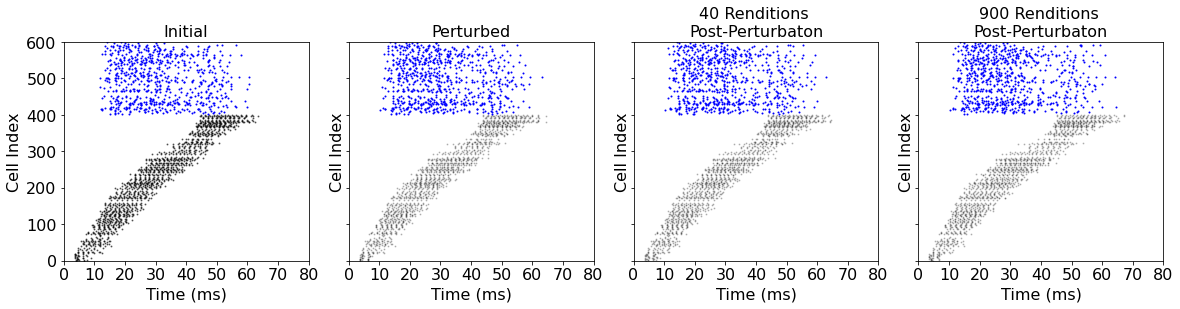

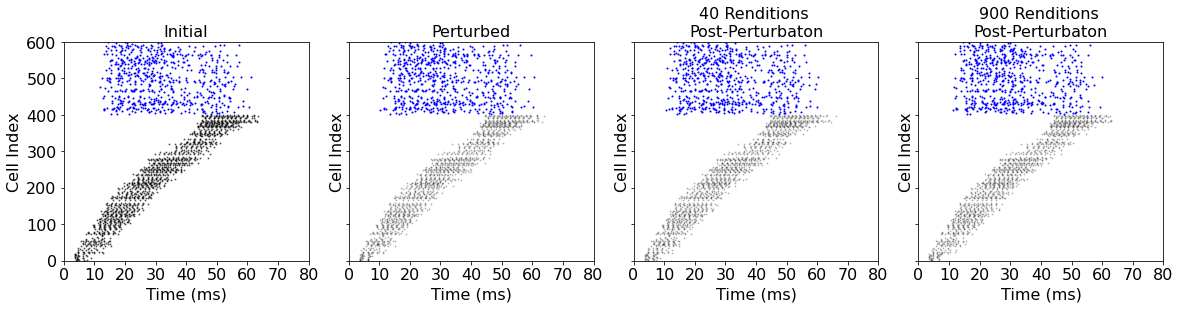

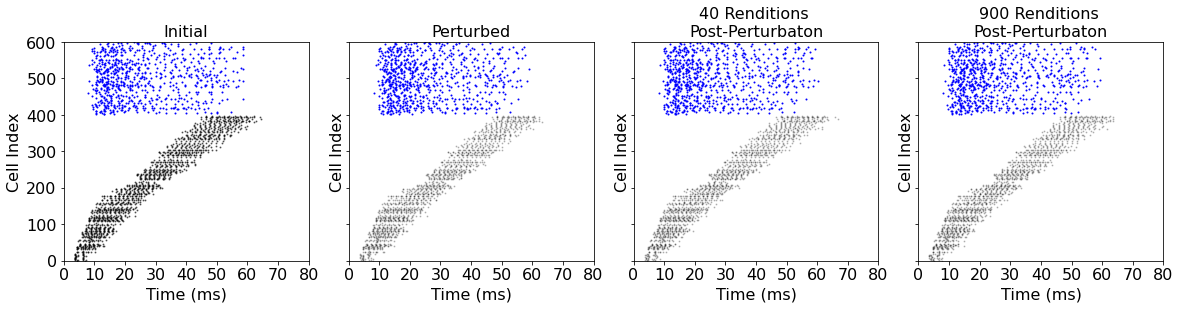

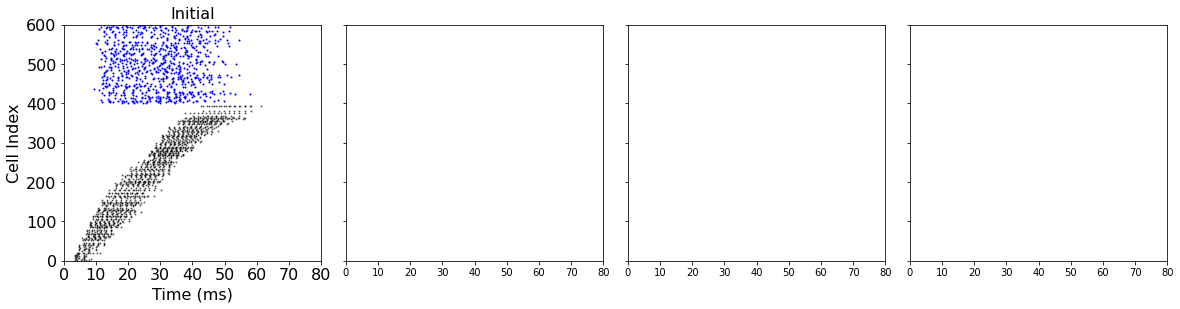

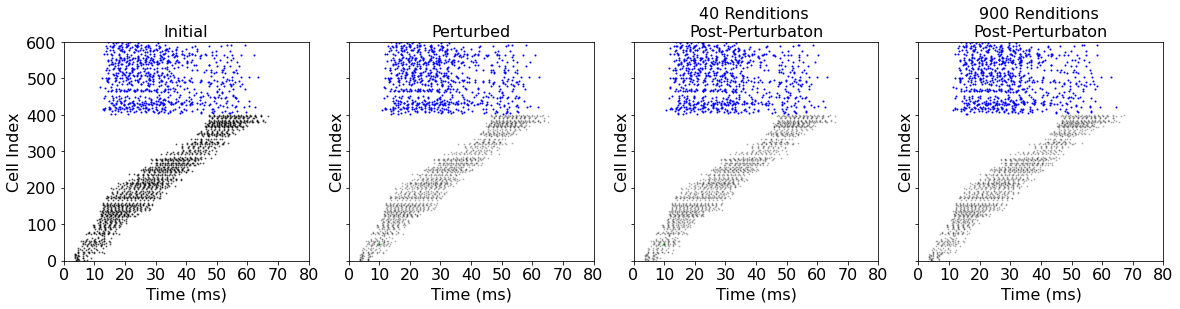

In [119]:
make_figure_1('pop')

## Figure 2: comparisons of the summed synaptic strengths per HVC(RA) cells for three cases: (1) single-cell rule + pop-level rule + STDP, (2) single-cell rule + STDP, (3) pop-level rule + STDP

In [89]:
def make_figure_2_plot(names, file_name_ext='', ylim=(0, 2), cap=100):
    scale = 1.4
    fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8 * scale, 5 * scale))
    
    all_dirs = []
    for name in names:
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
        
    spaced_colors = ['#171bff']
    labels = [
        'BTDP + population-level firing rate',
    ]
    
    for idx, exp_dir_names in enumerate(all_dirs):
        all_weights_for_dir_name = []
        for j, exp_dir_name in enumerate(exp_dir_names):
            all_mean_incoming_summed_weights = []
            all_std_incoming_summed_weights = []
            baseline_mean = None
            baseline_std = None

            for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=['dropout_0']):
                if i < cap:
                    all_mean_incoming_summed_weights.append(data['mean_incoming_summed_weights'])
                    all_std_incoming_summed_weights.append(data['std_incoming_summed_weights'])

                if i == 0:
                    baseline_mean = data['mean_incoming_summed_weights']
                    baseline_std = data['std_incoming_summed_weights']
            all_mean_incoming_summed_weights = np.array(all_mean_incoming_summed_weights) / baseline_mean
            all_std_incoming_summed_weights = np.array(all_std_incoming_summed_weights) / baseline_mean

            axs.plot(np.arange(cap) * 10, all_mean_incoming_summed_weights, lw=0.3, color=spaced_colors[idx])
                
            all_weights_for_dir_name.append(all_mean_incoming_summed_weights)
        
        axs.plot(np.arange(cap) * 10, np.array(all_weights_for_dir_name).mean(axis=0), lw=3., color=spaced_colors[idx], label=labels[idx])
        
        axs.set_xlim(0, 1000)
        axs.set_ylim(ylim[0], ylim[1])
        axs.set_xlabel('Network activations')
        axs.set_ylabel('Mean summed synapse strength')
        axs.legend()
        set_font_size(axs, 16)
    
    
    fig.tight_layout()
    save_fig(fig, './figures/paper/fig_2', f'mean_plot_{file_name_ext}.png')


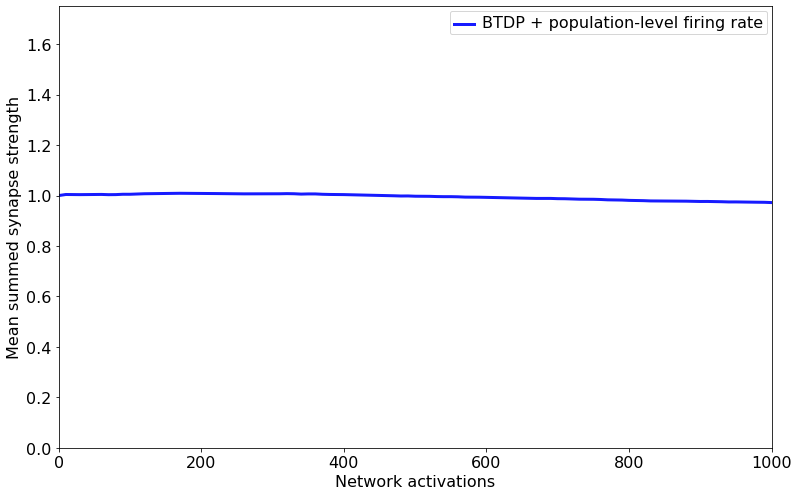

In [120]:
make_figure_2_plot(['pop_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.6_2021-06-11--09:06--51:5704'], ylim=(0, 1.75), cap=199)

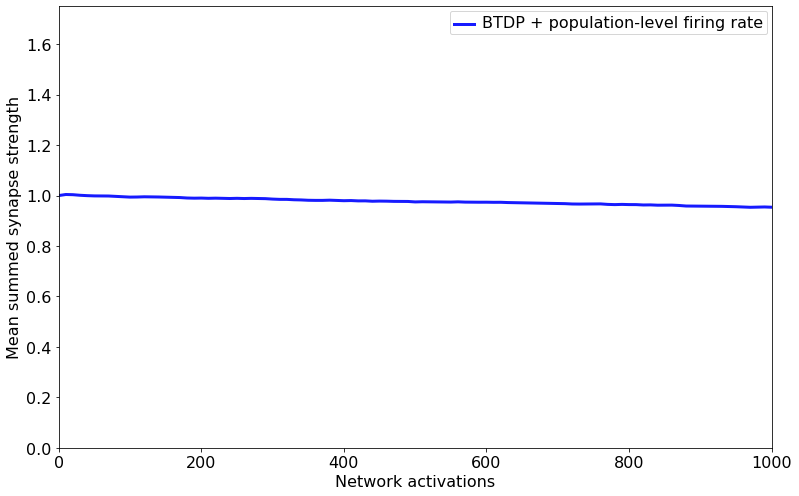

In [121]:
make_figure_2_plot(['pop_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.6_2021-06-11--09:15--33:1671'], ylim=(0, 1.75), cap=199)

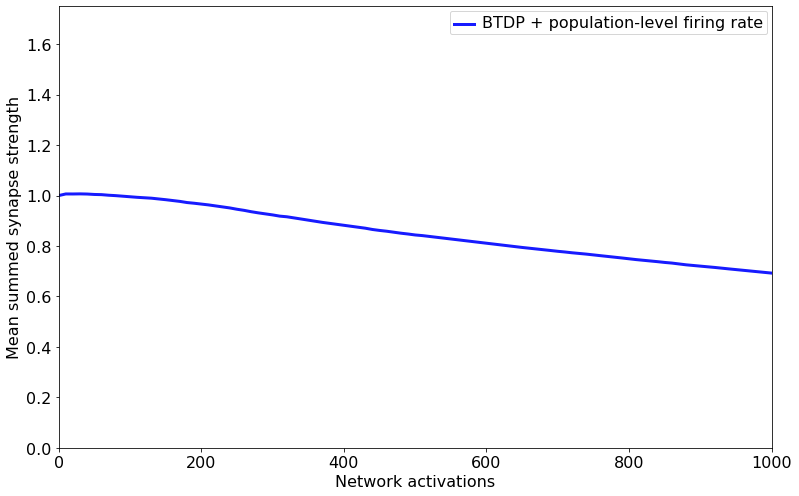

In [122]:
make_figure_2_plot(['pop_10x_btdp_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.6_2021-06-11--09:43--13:5704'], file_name_ext='10x_btdp', ylim=(0, 1.75), cap=199)

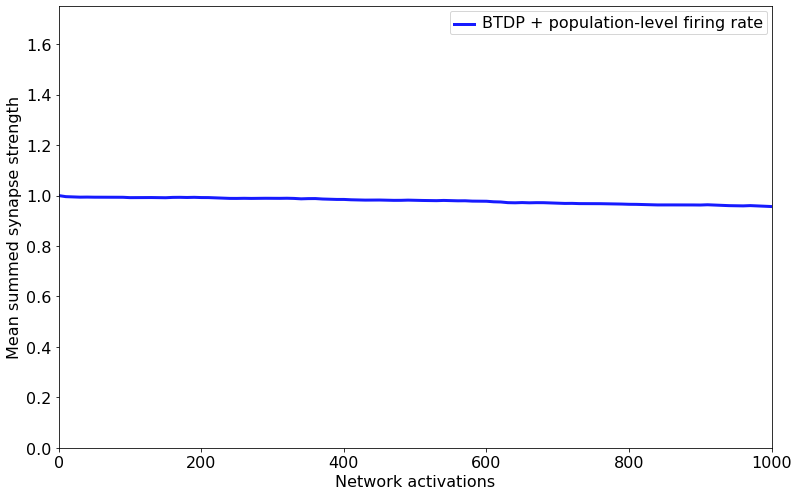

In [123]:
make_figure_2_plot(['pop_middle_bulge_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.6_2021-06-11--10:04--15:5704'], file_name_ext='pop_bulge', ylim=(0, 1.75), cap=199)

In [134]:
def make_figure_3(names, ylim=(0, 8), trials=[0]):    
    all_dirs = []
    for name in names:
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
        
    spaced_colors = ['#1f22ff', 'black', '#ff1f71', '#ff1f71']
    labels = [
        'unperturbed',
        'perturbed',
        '100th rendition',
        '1900th rendition',
    ]
    
    for i_t in trials:
        scale = 1.1
        fig, axs = plt.subplots(2, 4, sharex=True, sharey=False, figsize=(20 * scale, 8 * scale))
        
        for idx, exp_dir_names in enumerate(all_dirs):
            timepoints = [9, 10, 20, 199]
            j = 0
            spk_bins_zero = None
            freqs_zero = None
            exp_dir_names = sorted(exp_dir_names, key=lambda x: x[-4:])
            print(exp_dir_names)
            for i, data in load_exp_data(os.path.join('./robustness', exp_dir_names[i_t]), name_frags=['dropout_0']):
                if j < len(timepoints) and i == timepoints[j]:
                    if j > 0:
                        if idx == 0:
                            axs[idx, j].bar(spk_bins_zero, freqs_zero, color=spaced_colors[0], alpha=0.2, zorder=-j, width=1, label=labels[0])
                        else:
                            axs[idx, j].bar(spk_bins_zero, freqs_zero, color=spaced_colors[0], alpha=0.2, zorder=-j, width=1)

                    spk_bins = data['spk_bins']
                    freqs = data['freqs']
                    if j == 0:
                        spk_bins_zero = spk_bins
                        freqs_zero = freqs

                    if idx == 0:
                        axs[idx, j].bar(spk_bins, freqs, color=spaced_colors[j], alpha=0.7, zorder=-j, width=1, label=labels[j])
                    else:
                        axs[idx, j].bar(spk_bins, freqs, color=spaced_colors[j], alpha=0.7, zorder=-j, width=1)
                    axs[idx, j].set_ylabel('Frequency')
                    if idx == (len(all_dirs) - 1):
                        axs[idx, j].set_xlabel('Spikes per neuron')
                    axs[idx, j].set_xlim(-0.5, 20)
                    axs[idx, j].set_ylim(0, 500)

                    if idx == 0:
                        axs[0, j].legend()

                    set_font_size(axs[idx, j], 18)
                    j += 1
        plt.locator_params(axis='x', nbins=5)
        fig.tight_layout()
        save_fig(fig, './figures/paper/fig_3', f'trial_{i_t}.png')

## Figure 3: comparisons of the firing rate distributions of HVC(RA) cells for three cases: (1) single-cell rule + pop-level rule + STDP, (2) single-cell rule + STDP, (3) pop-level rule + STDP

### First run only

(1) BTDP + single-cell firing rate upper bound + popopulation-level firing rate

(2) BTDP + population-level firing rate

(3) BTDP + single-cell rule (NOTE: single cell setpoints were artificial & silent cells were drawn in early)

### All runs

['pop_10x_btdp_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.6_2021-06-11--09:43--13:5704']
['pop_10x_btdp_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.6_2021-06-11--09:43--13:5704']


IndexError: list index out of range

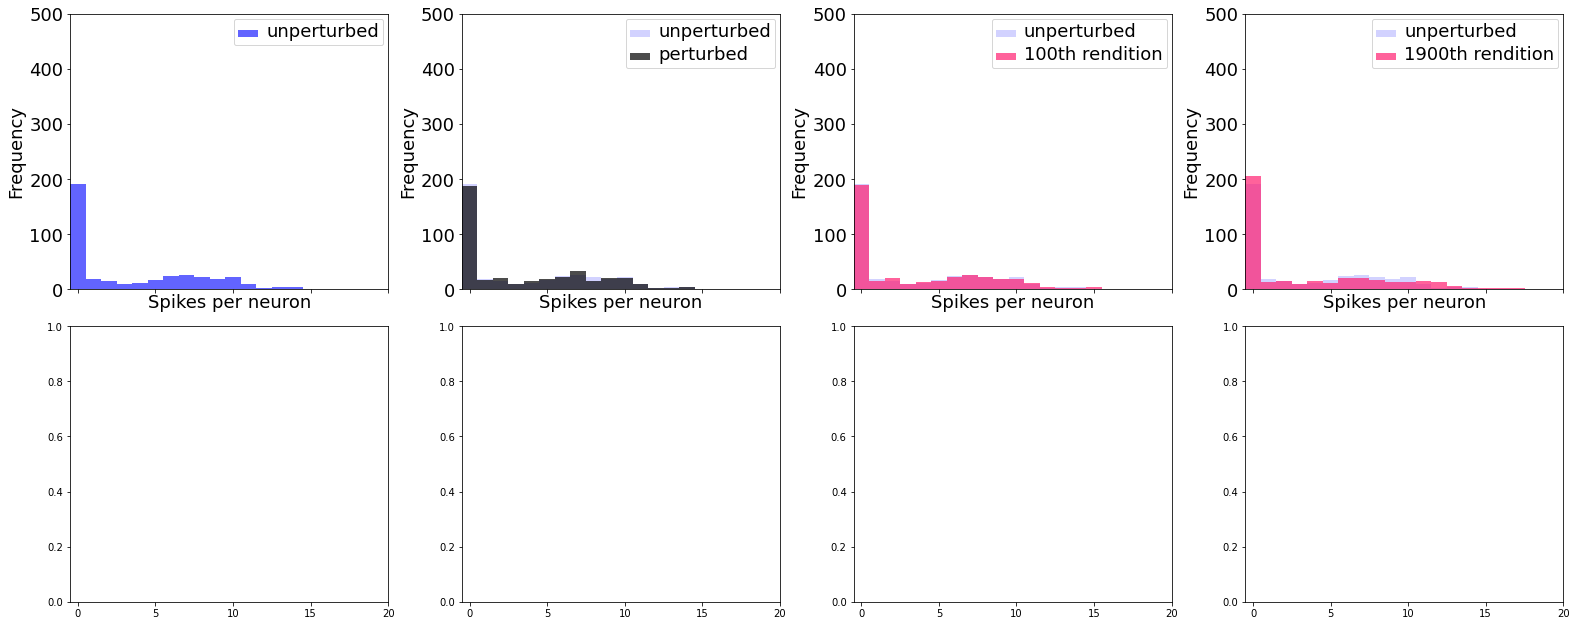

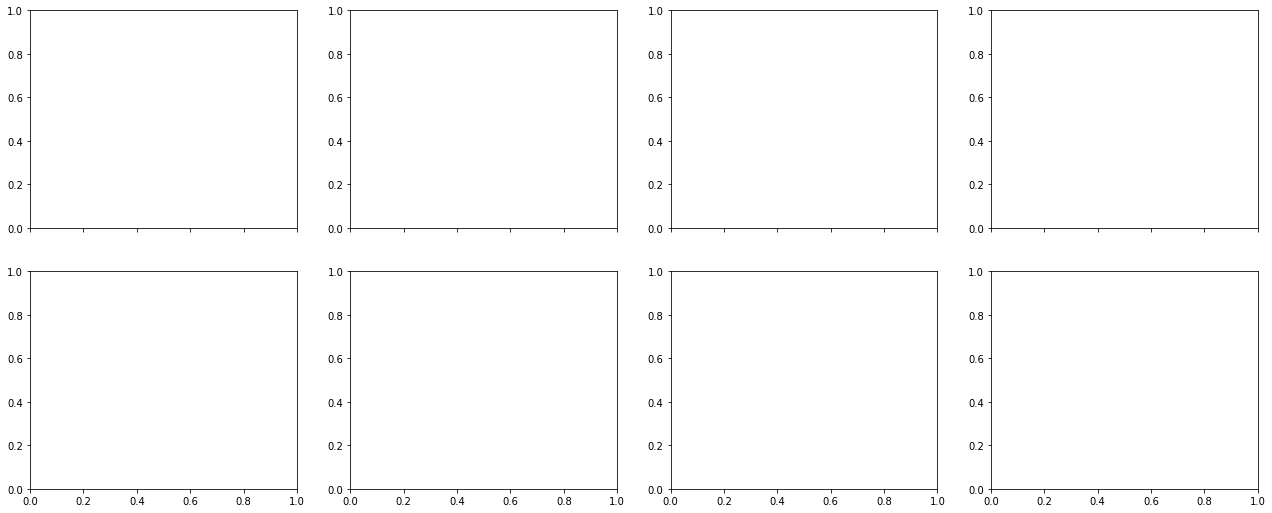

In [135]:
make_figure_3(['pop_10x_btdp_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.6_2021-06-11--09:43--13:5704'], trials=np.arange(5))

In [226]:
def make_figure_4_averaged(names, dropout=0, file_name_ext='', ylim=(0, 8)):
    scale = 1.4
    fig, axs = plt.subplots(4, 1, sharex=False, sharey=False, figsize=(10 * scale, 12 * scale))
    
    all_dirs = []
    for name in names:
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])

    x = np.concatenate([np.ones(20) * i for i in range(0, 900, 20)])
    cap = 195
    spaced_colors = ['#ff1717', '#d117ff', '#171bff']
    labels = [
        'BTDP + single-cell firing rate',
        'BTDP + single-cell firing rate \n+ population-level firing rate',
        'BTDP + population-level firing rate',
    ]
    
    for idx, exp_dir_names in enumerate(all_dirs):
        to_plot = ['pop_firing_rates', 'relative_prop_speeds', 'r_squareds', 'last_layer_actives']
        
        plot_data = {}
        for var in to_plot:
            plot_data[var] = {'raw': []}
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            
            for var in to_plot:
                plot_data[var]['raw'].append([])

            for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=[f'dropout_{dropout}']):
                if i == cap:
                    break

                pop_firing_rate = np.sum(data['exc_cells_initially_active'])
                if data['exc_cells_newly_active'] is not None:
                    pop_firing_rate += np.sum(data['exc_cells_newly_active'])
                plot_data['pop_firing_rates']['raw'][-1].append(pop_firing_rate)

                first_spk_times = data['first_spk_times']
                filtered_indices = data['surviving_cell_indices'] & (~np.isnan(first_spk_times))

                x_firing = x[filtered_indices]
                first_spk_times_nonnan = first_spk_times[filtered_indices]

                res = stats.linregress(x_firing, first_spk_times_nonnan)
                plot_data['relative_prop_speeds']['raw'][-1].append(res.slope)
                plot_data['r_squareds']['raw'][-1].append(np.square(res.rvalue))
                plot_data['last_layer_actives']['raw'][-1].append(data['last_layer_active'])
                
        for var in to_plot:
            l = len(plot_data[var]['raw'])
            plot_data[var]['raw'] = np.stack(plot_data[var]['raw'])
            plot_data[var]['means'] = plot_data[var]['raw'].mean(axis=0)
            plot_data[var]['stds'] = plot_data[var]['raw'].std(axis=0)
            
        epochs = np.arange(0, cap * 10, 10)
        
        axs[0].fill_between(
            epochs,
            plot_data['pop_firing_rates']['means'] - plot_data['pop_firing_rates']['stds'],
            plot_data['pop_firing_rates']['means'] + plot_data['pop_firing_rates']['stds'],
            color=spaced_colors[idx], alpha=0.15
        )
        axs[0].plot(epochs, plot_data['pop_firing_rates']['means'], c=spaced_colors[idx], lw=1., label=labels[idx])
        axs[1].fill_between(
            epochs,
            plot_data['relative_prop_speeds']['means'] - plot_data['relative_prop_speeds']['stds'],
            plot_data['relative_prop_speeds']['means'] + plot_data['relative_prop_speeds']['stds'],
            color=spaced_colors[idx], alpha=0.15
        )
        axs[1].plot(epochs, plot_data['relative_prop_speeds']['means'], c=spaced_colors[idx], lw=1.)
        axs[2].fill_between(
            epochs,
            plot_data['r_squareds']['means'] - plot_data['r_squareds']['stds'],
            plot_data['r_squareds']['means'] + plot_data['r_squareds']['stds'],
            color=spaced_colors[idx], alpha=0.15
        )
        axs[2].plot(epochs, plot_data['r_squareds']['means'],c=spaced_colors[idx], lw=1.)
        axs[3].fill_between(
            epochs,
            plot_data['last_layer_actives']['means'] - plot_data['last_layer_actives']['stds'],
            plot_data['last_layer_actives']['means'] + plot_data['last_layer_actives']['stds'],
            color=spaced_colors[idx], alpha=0.15
        )
        axs[3].plot(epochs, plot_data['last_layer_actives']['means'], c=spaced_colors[idx], lw=1.)
        
    axs[0].set_ylabel('Population spikes\nper activation')
    axs[1].set_ylabel('Propagation speed')
    axs[2].set_ylabel(r'$R^2$')
    axs[3].set_ylabel('Last layer active')
    
    axs[2].set_ylim(0.5, 1.)
    axs[3].set_ylim(0, 45)
    
    axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
    for i in range(4):
        axs[i].set_xlim(0, cap * 10)
        axs[i].set_xlabel('Epochs')
        set_font_size(axs[i], 16)
    fig.tight_layout()
    save_fig(fig, './figures/paper/fig_4', f'dropout_{int(50 + dropout * 10)}_{file_name_ext}.png')

## Figure 4: metrics of dynamics

### 50% dropout of HVC(RA) projectors

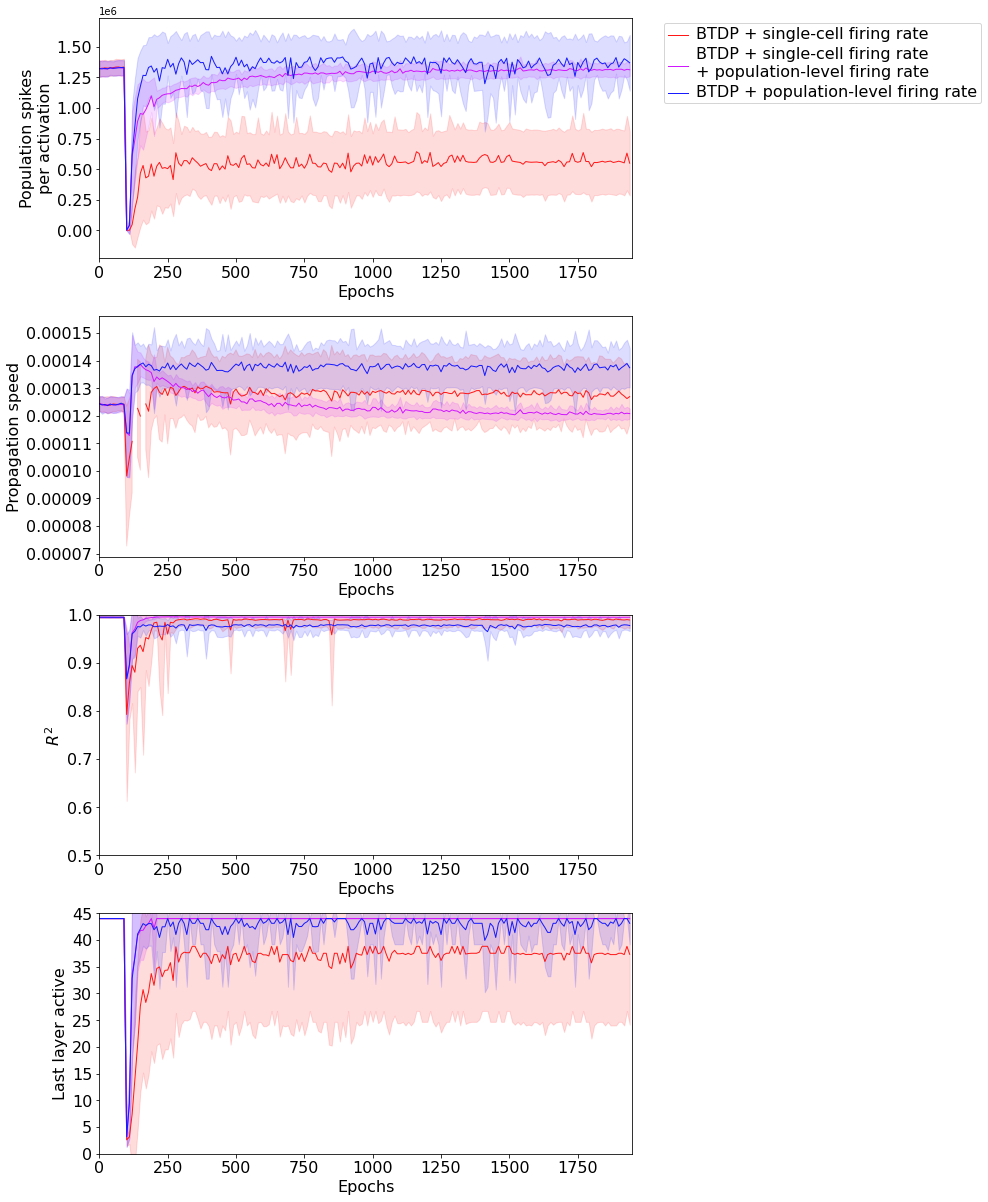

In [227]:
make_figure_4_averaged(['single_cell', 'all_rules', 'pop'], file_name_ext='both_rules')

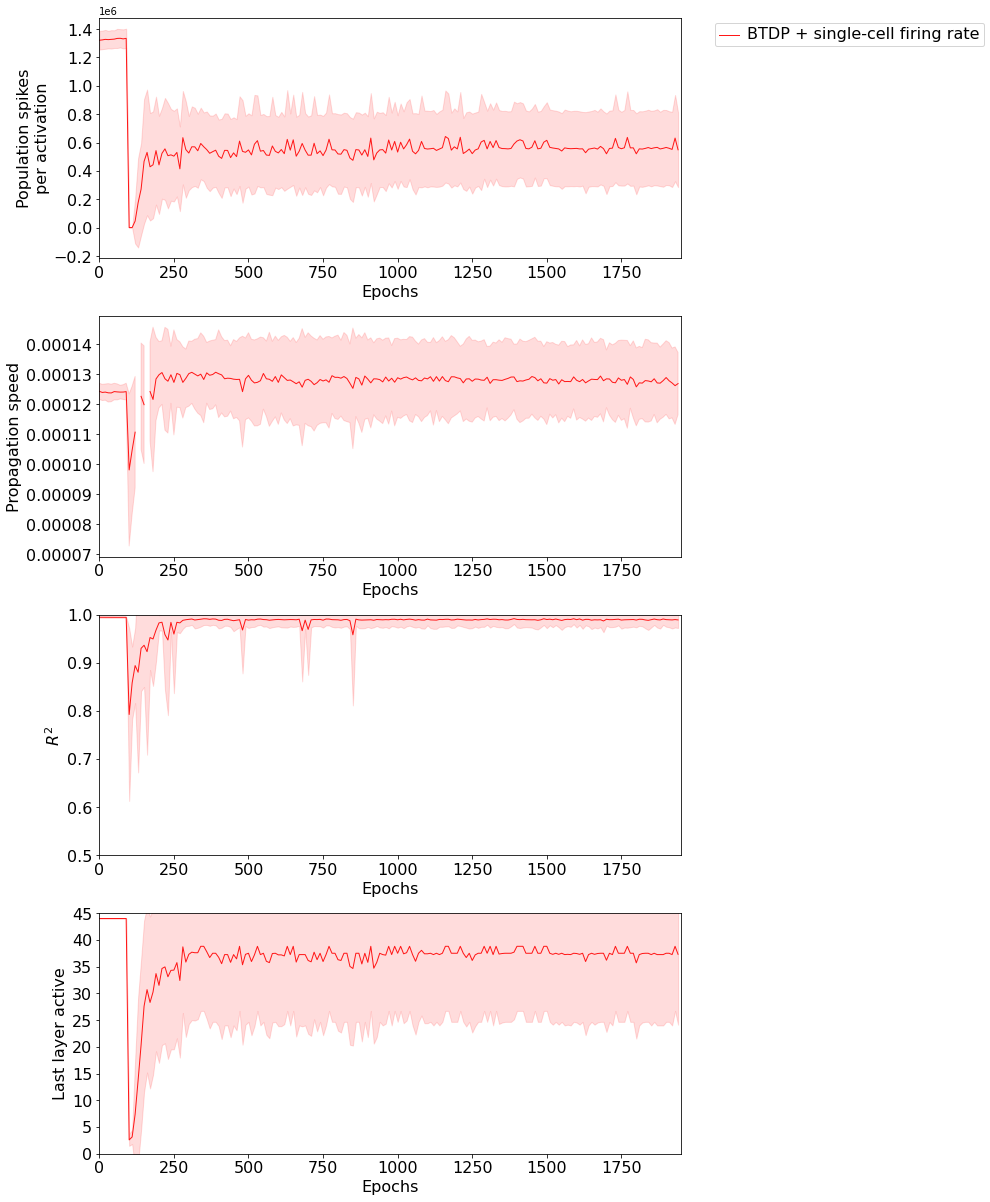

In [207]:
make_figure_4_averaged(['single_cell'], file_name_ext='single_only')

### 60% dropout of HVC(RA) projectors

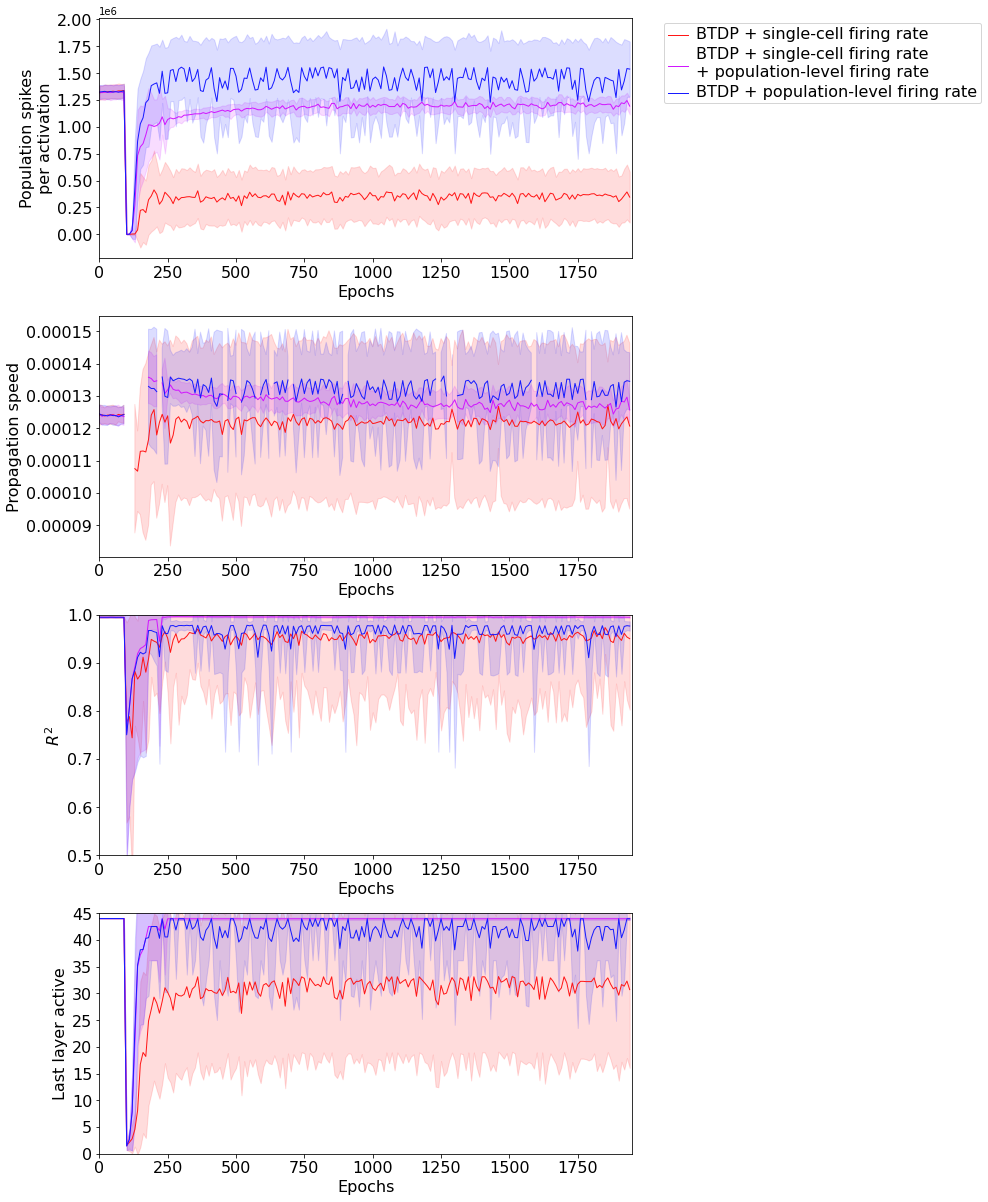

In [234]:
make_figure_4_averaged(['single_cell', 'all_rules', 'pop'], dropout=1)

### 70% dropout of HVC(RA) projectors

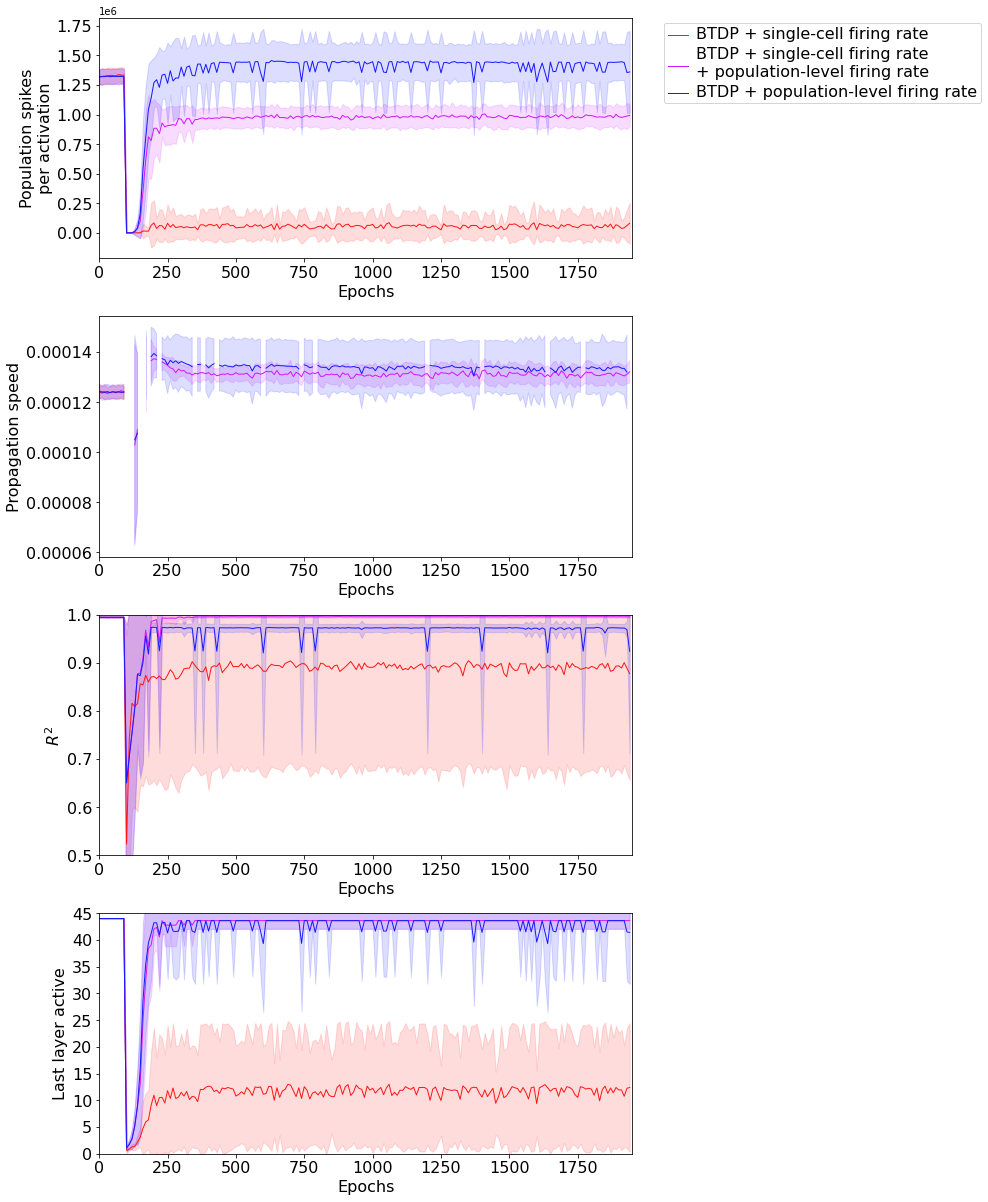

In [235]:
make_figure_4_averaged(['single_cell', 'all_rules', 'pop'], dropout=2)

# Past this point, things are very much uncertain

### 80% dropout of HVC(RA) projectors

ValueError: all input arrays must have the same shape

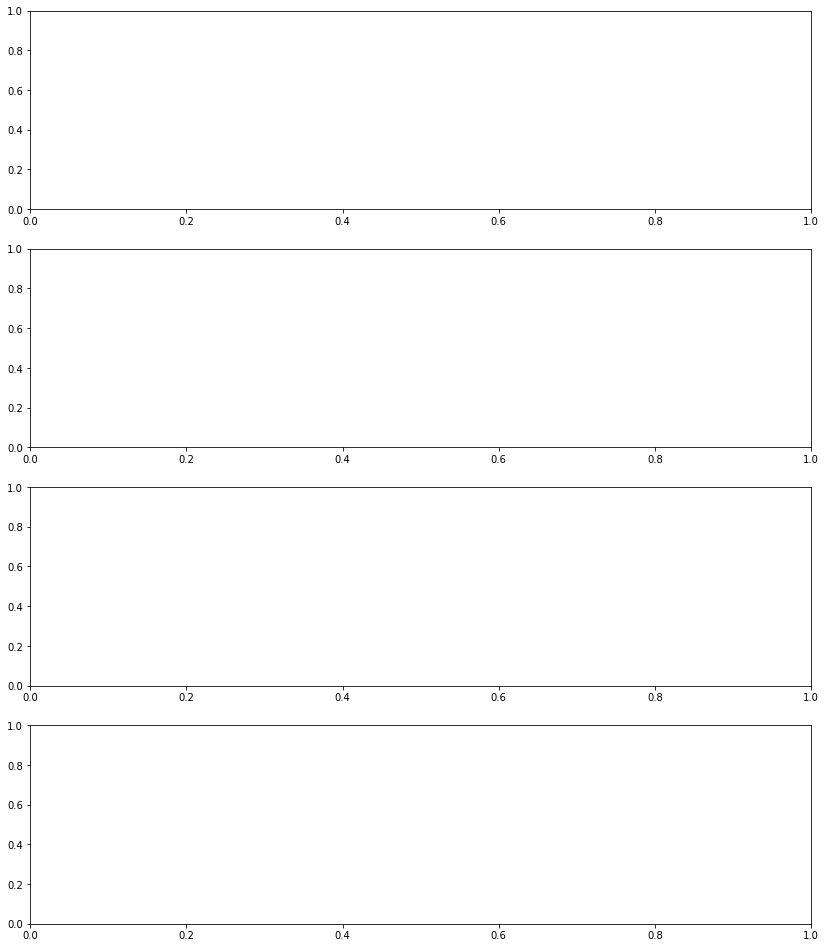

In [236]:
make_figure_4_averaged(['single_cell', 'all_rules', 'pop'], dropout=3)

### 90% dropout of HVC(RA) projectors

In [ ]:
make_figure_4_averaged(['single_cell', 'all_rules', 'pop'], dropout=4)

In [223]:
def make_figure_4(names, dropout=0, ylim=(0, 8)):
    scale = 1.1
    fig, axs = plt.subplots(4, 1, sharex=False, sharey=False, figsize=(8 * scale, 12 * scale))
    
    all_dirs = []
    for name in names:
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])

    x = np.concatenate([np.ones(20) * i for i in range(0, 900, 20)])
    cap = 199
    spaced_colors = ['#d117ff', '#171bff', '#ff1717']
    labels = [
        'BTDP + single-cell firing rate + population-level firing rate',
        'BTDP + population-level firing rate',
        'BTDP + single-cell firing rate',
    ]
    
    for idx, exp_dir_names in enumerate(all_dirs):
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            pop_firing_rates = []
            relative_prop_speeds = []
            r_squareds = []
            last_layer_actives = []

            for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=[f'dropout_{dropout}']):
                if i == cap:
                    break

                pop_firing_rate = np.sum(data['exc_cells_initially_active'])
                if data['exc_cells_newly_active'] is not None:
                    pop_firing_rate += np.sum(data['exc_cells_newly_active'])
                pop_firing_rates.append(pop_firing_rate)

                first_spk_times = data['first_spk_times']
                filtered_indices = data['surviving_cell_indices'] & (~np.isnan(first_spk_times))

                x_firing = x[filtered_indices]
                first_spk_times_nonnan = first_spk_times[filtered_indices]

                res = stats.linregress(x_firing, first_spk_times_nonnan)
                relative_prop_speeds.append(res.slope)
                r_squareds.append(np.square(res.rvalue))
                last_layer_actives.append(data['last_layer_active'])

            epochs = np.arange(0, cap * 10, 10)
            
            epochs_0 = epochs[:len(pop_firing_rates)]
            axs[0].plot(epochs_0, pop_firing_rates, c=spaced_colors[idx], lw=0.7)
#             if j == 0:
#                 axs[1].plot(epochs, relative_prop_speeds, c=spaced_colors[idx], lw=1., label=labels[i])
#             else: 
            epochs_1 = epochs[:len(relative_prop_speeds)]
            axs[1].plot(epochs_1, relative_prop_speeds, c=spaced_colors[idx], lw=0.7)
            epochs_2 = epochs[:len(r_squareds)]
            axs[2].plot(epochs_2, r_squareds,c=spaced_colors[idx], lw=0.7)
            epochs_3 = epochs[:len(last_layer_actives)]
            axs[3].plot(epochs_3, last_layer_actives, c=spaced_colors[idx], lw=0.7)
        
        axs[0].set_ylabel('Population spks\nper activation')
        axs[1].set_ylabel('Propagation speed')
        axs[2].set_ylabel(r'$R^2$')
        axs[3].set_ylabel('Last layer active')
        axs[3].set_xlabel('Epochs')
        
        for i in range(4):
            axs[i].set_xlim(0, cap * 10)
            set_font_size(axs[i], 16)
    
    fig.tight_layout()

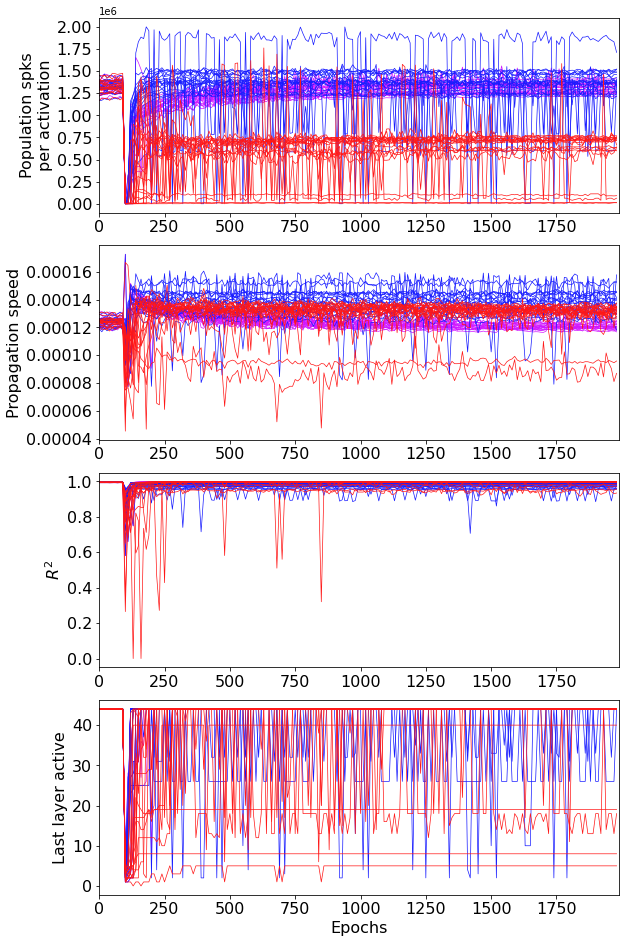

In [224]:
make_figure_4(['all_rules', 'pop','single_cell'])

KeyboardInterrupt: 

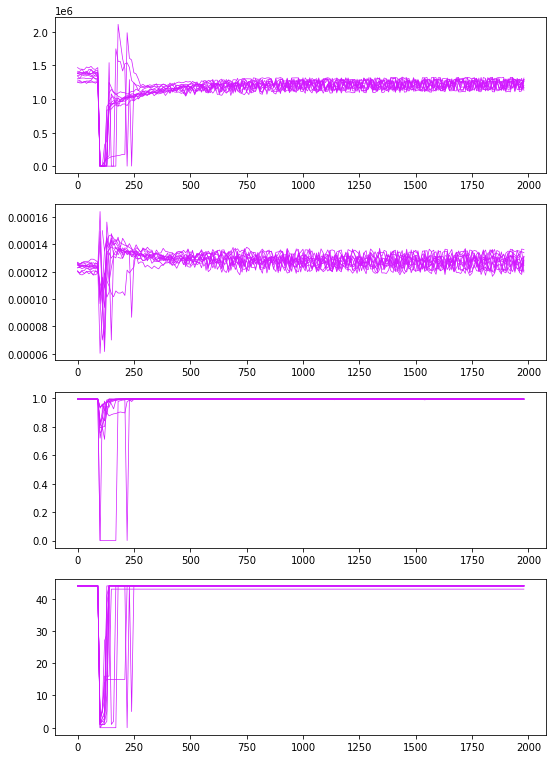

In [225]:
make_figure_4(['all_rules', 'pop','single_cell'], dropout=1)

In [ ]:
make_figure_4(['all_rules', 'pop','single_cell'], dropout=2)

In [ ]:
make_figure_4(['all_rules', 'pop','single_cell'], dropout=3)

In [ ]:
make_figure_4(['all_rules', 'pop','single_cell'], dropout=4)

In [ ]:
def make_figure_2_alt(names, ylim=(0, 8)):
    scale = 1.1
    fig, axs = plt.subplots(3, 1, sharex=False, sharey=True, figsize=(8 * scale, 10 * scale))
    
    all_dirs = []
    for name in names:
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
        
    spaced_colors = ['#d117ff', '#171bff', '#ff1717']
    labels = [
        'BTDP + single-cell firing rate + population-level firing rate',
        'BTDP + population-level firing rate',
        'BTDP + single-cell firing rate',
    ]
    
    step = 5
    cap=79
    
    for idx, exp_dir_name in enumerate(all_dirs):
        all_incoming_summed_weights = []
        
        for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name[0]), name_frags=['dropout_0']):
            if i % step != 0:
                continue
            if i >= cap:
                break
            all_incoming_summed_weights.append(data['summed_incoming_weights'])
        
        x = np.arange(0, cap, step)
        parts = axs[idx].violinplot(all_incoming_summed_weights, x, widths=np.ones(len(x)) * step * 0.5,
                      showmedians=True)
        
        axs[idx].set_xlim(-0.5 * step, cap)
        axs[idx].set_ylim(ylim[0], ylim[1])
        if idx == len(all_dirs) - 1:
            axs[idx].set_xlabel('Network activations')
        axs[idx].set_ylabel('Summed synapse strength\n onto excitatory cells')
#         axs.legend()

        for pc in parts['bodies']:
            pc.set_facecolor(spaced_colors[idx])
            pc.set_edgecolor(spaced_colors[idx])
            pc.set_alpha(0.5)
        
        for part_type in ['cmaxes', 'cmins', 'cbars', 'cmedians']:
            parts[part_type].set_color('black')
            
        
    fig.tight_layout()

In [ ]:
make_figure_2_alt([
    'all_rules_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.3_2021-05-27--00:13--44:1354',
    'pop_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.3_2021-05-27--00:13--44:1354',
    'single_cell_ff_1.6_pf_0.7_pr_0.0_eir_2.0_ier_0.3_2021-05-27--00:13--44:1354',
], ylim=(-0.0001, 0.008))

In [84]:
def make_figure_5(name, color='black'):
    
    all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [name])
    
    for exp_dir_name in sorted(all_dirs):
        scale = 1.1
        fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(15 * scale, 4 * scale))
        
        timepoints = [9, 10, 14, 199]
        timepoint_names = ['Initial', 'Perturbed', '40 Renditions \nPost-Perturbaton', '1900 Renditions \nPost-Perturbaton']
        j = 0
        for i, data in load_exp_data(os.path.join('./robustness', exp_dir_name),
                                 name_frags=['dropout_0']):
            
            if j < len(timepoints) and i == timepoints[j]:
                summed_incoming_weights = data['summed_incoming_weights'].reshape(data['summed_incoming_weights'].shape[1])
                layer_weights = np.array([np.sum(summed_incoming_weights[i:i+20]) for i in range(0, summed_incoming_weights.shape[0], 20)])
                x = np.arange(summed_incoming_weights.shape[0])
                
                axs[j].scatter(x, summed_incoming_weights, s=1, c=color, zorder=0, alpha=1)

                axs[j].set_xlim(-1, 901)
                axs[j].set_xlabel('Cell Index')
                axs[j].set_ylabel('Summed Incoming Weights')
                axs[j].title.set_text(f'{timepoint_names[j]}')
                set_font_size(axs[j], 16)
                j += 1
    
        fig.tight_layout()
#         save_fig(fig, './figures/paper/fig_1', f'{exp_dir_name}.png')

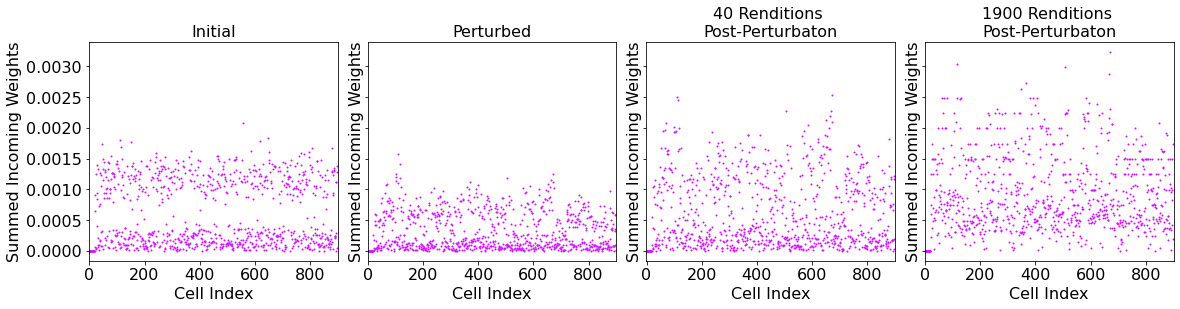

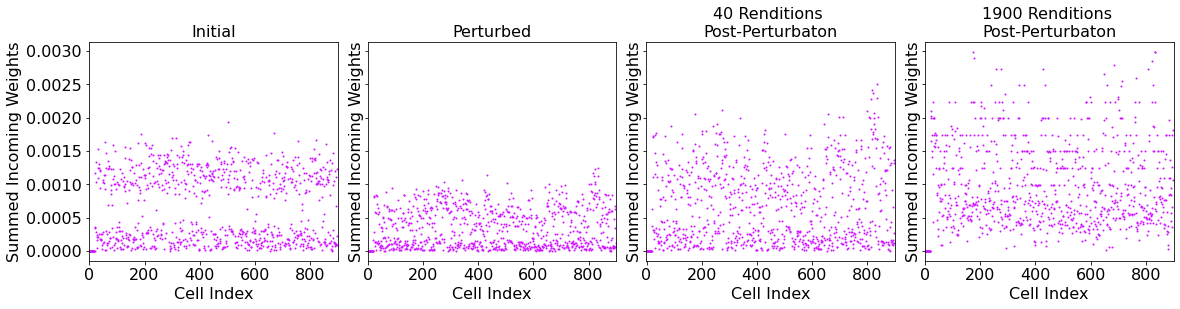

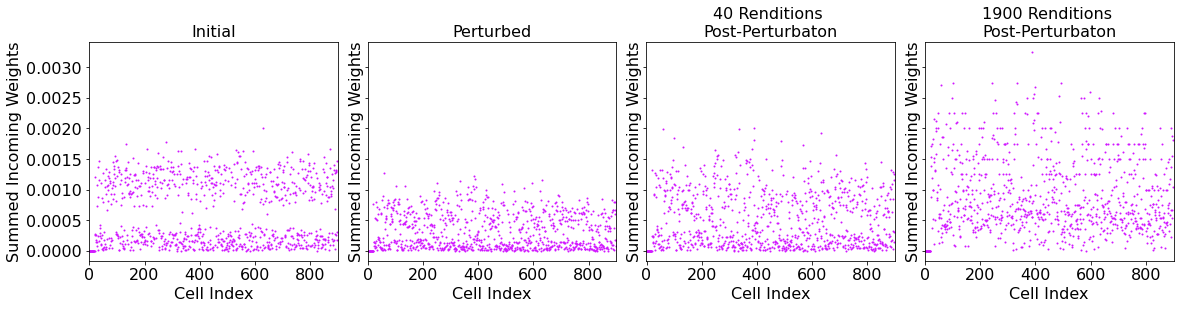

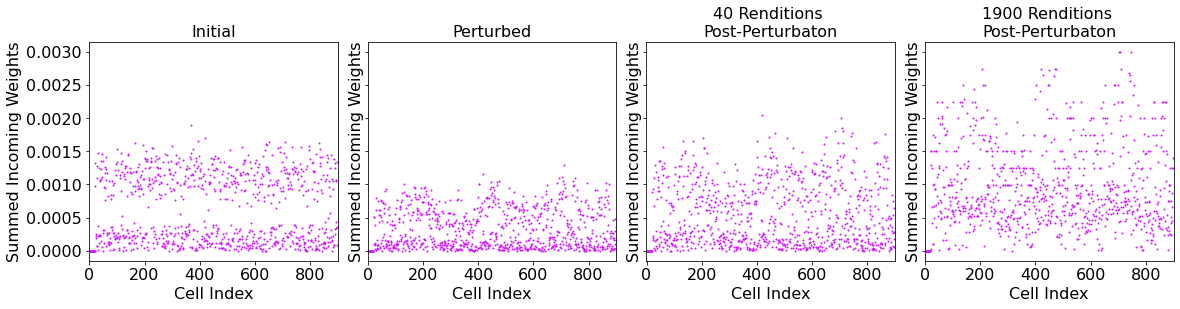

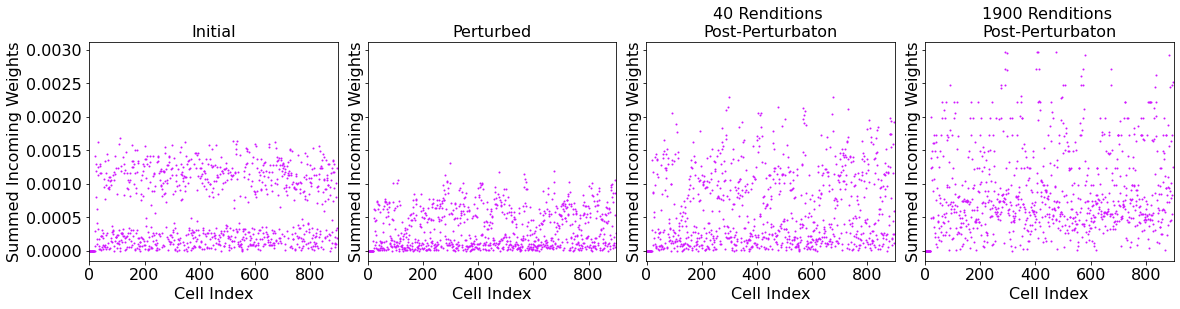

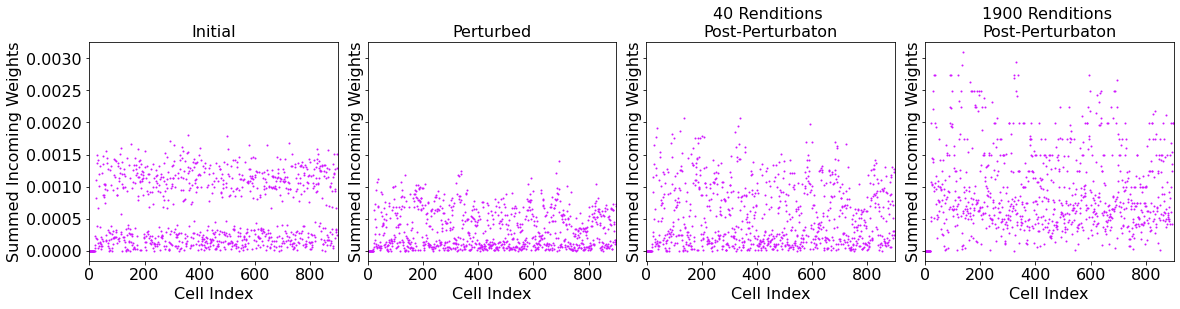

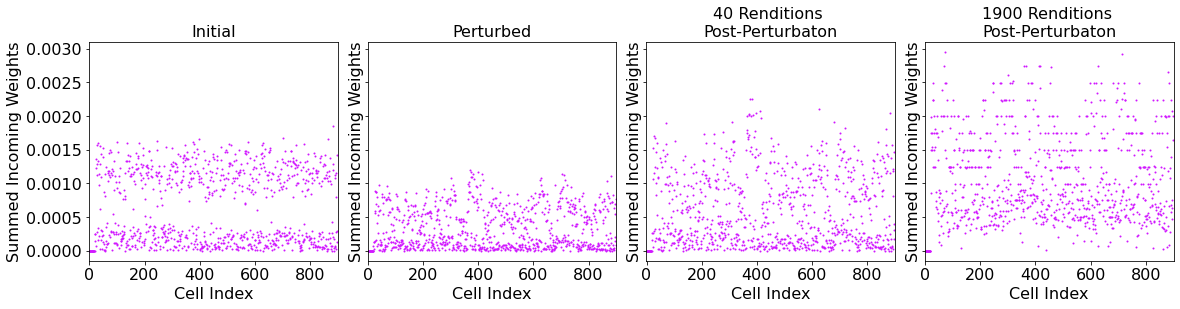

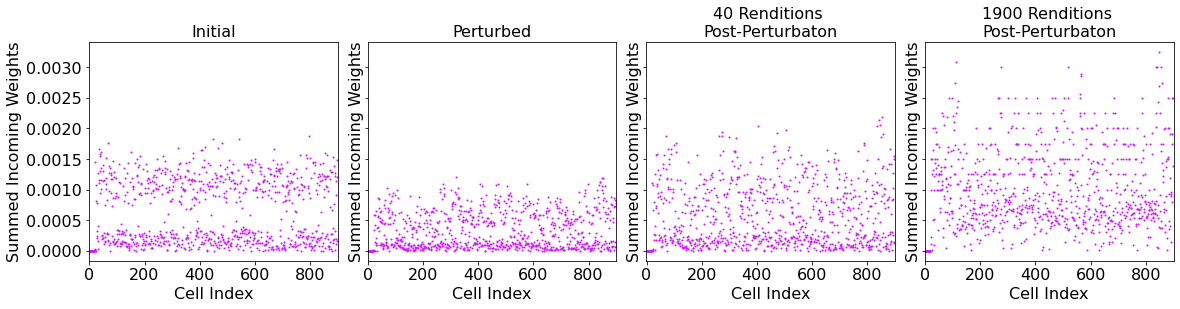

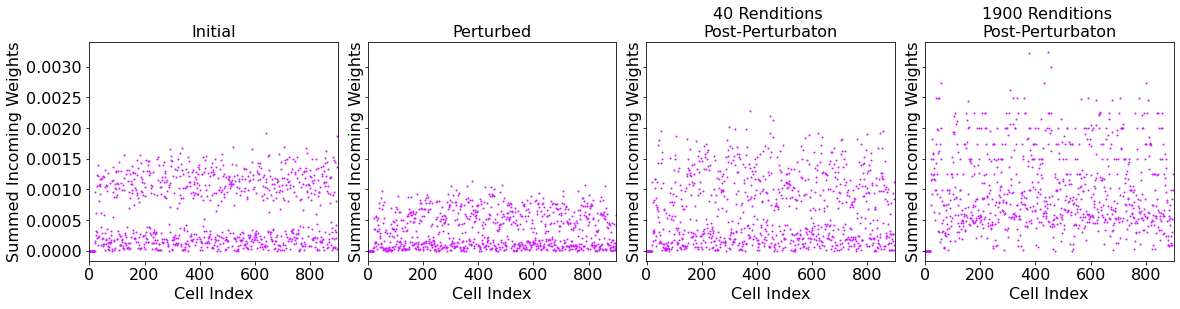

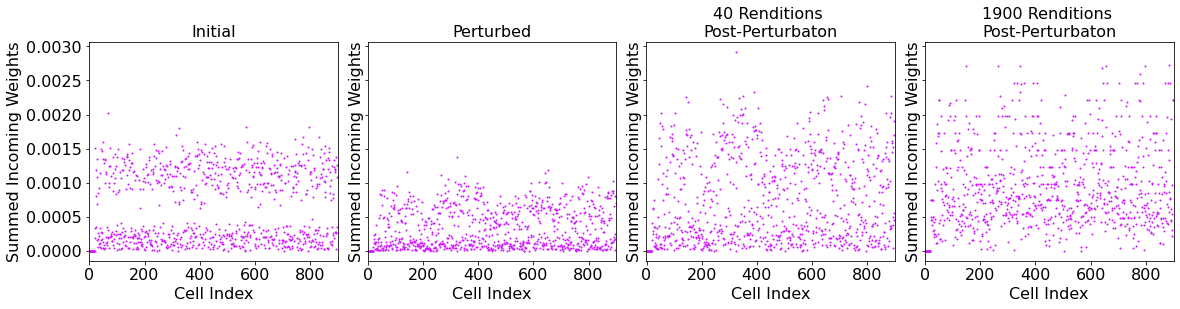

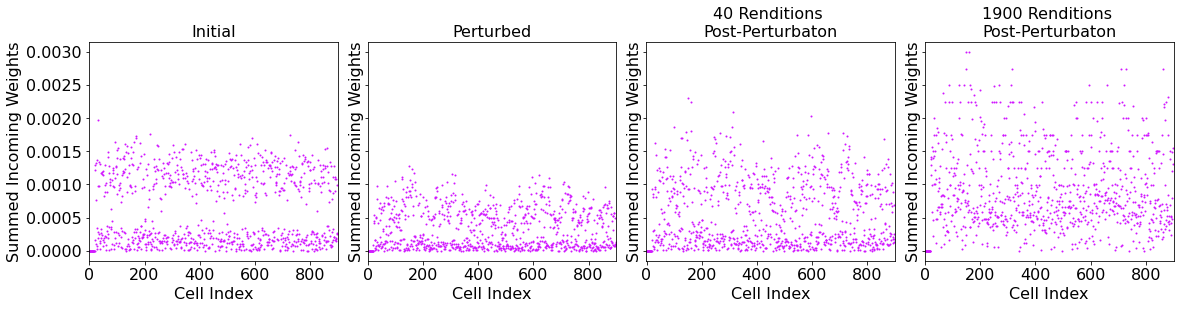

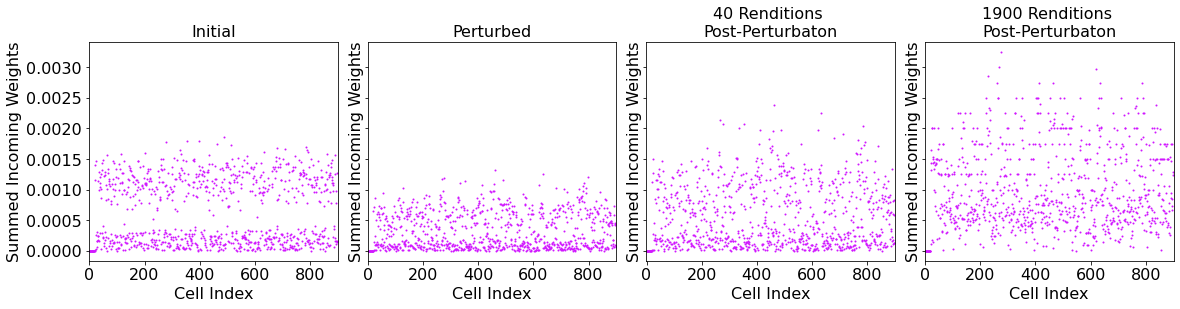

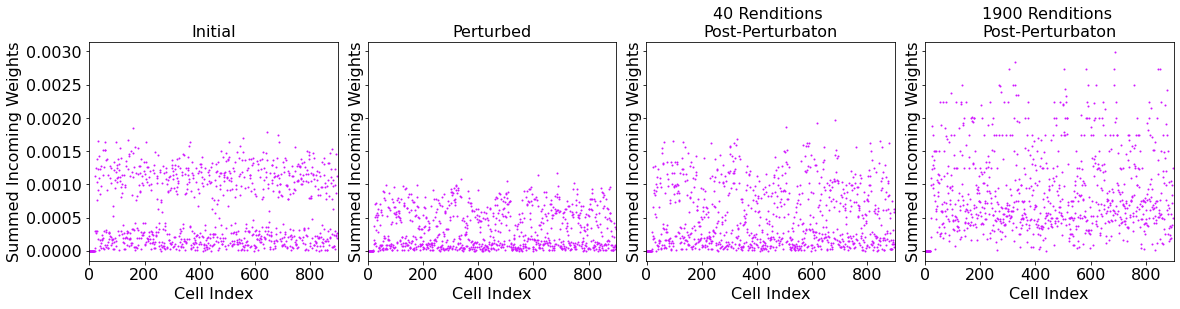

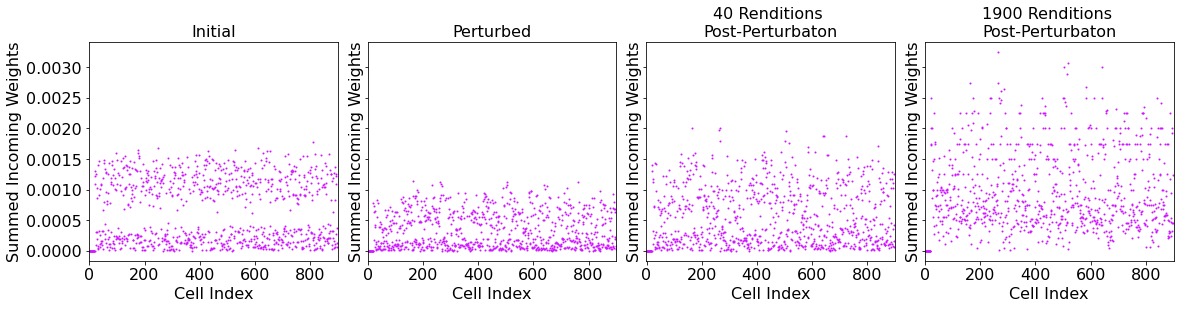

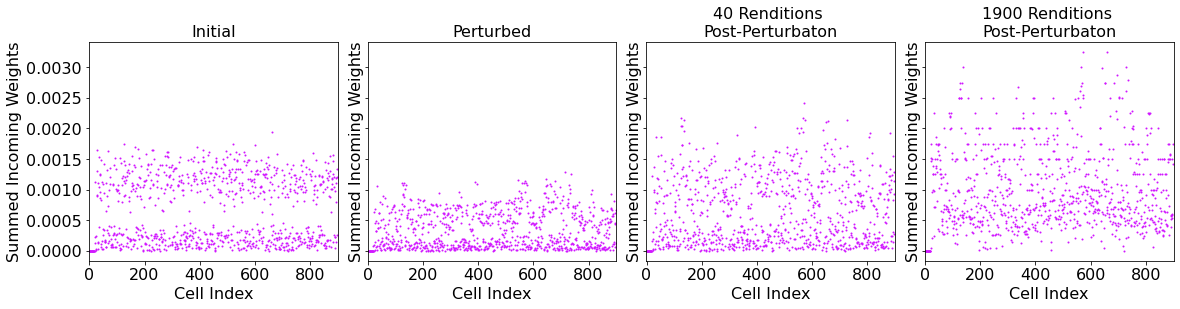

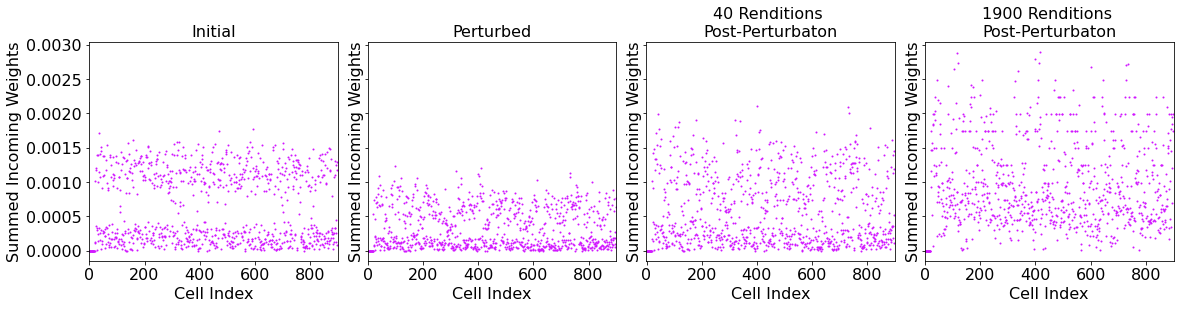

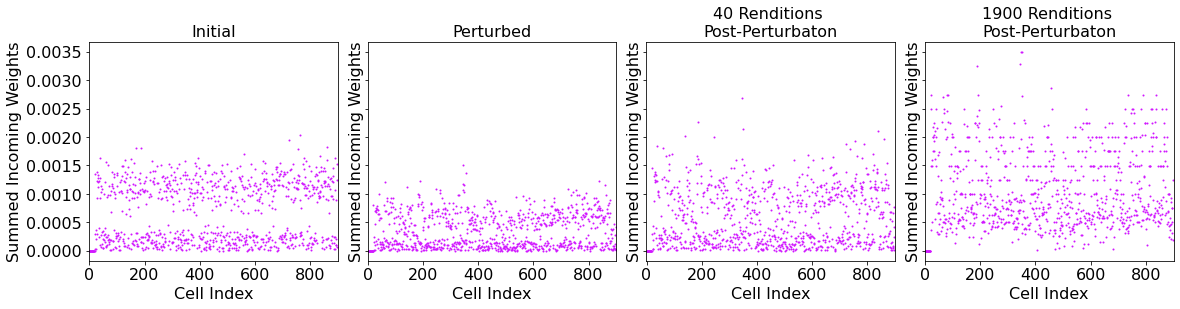

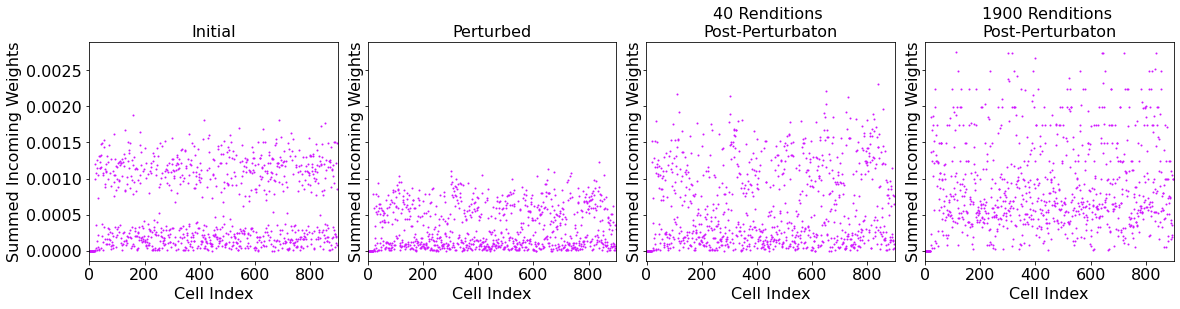

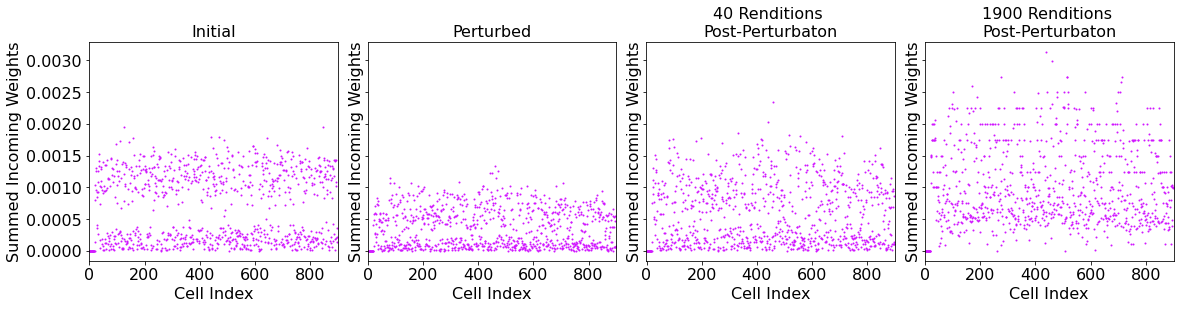

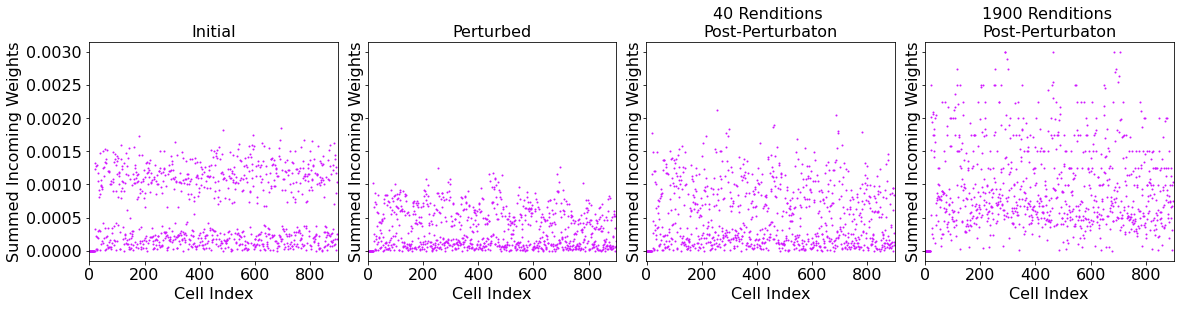

In [85]:
make_figure_5('all_rules', '#d117ff')

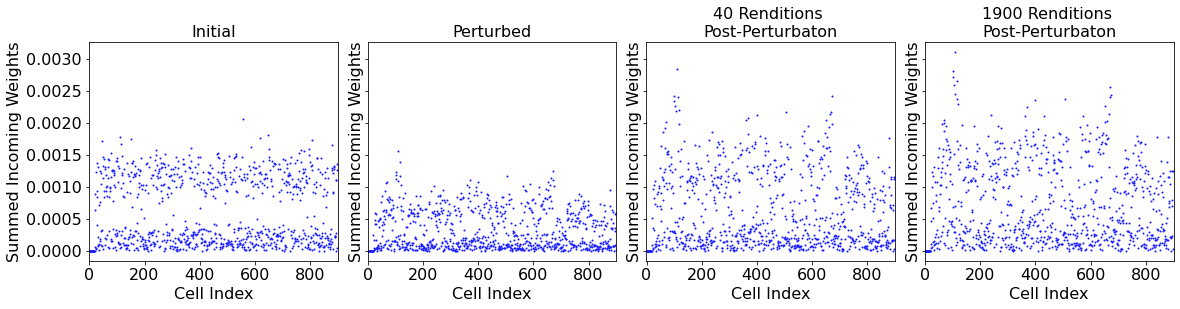

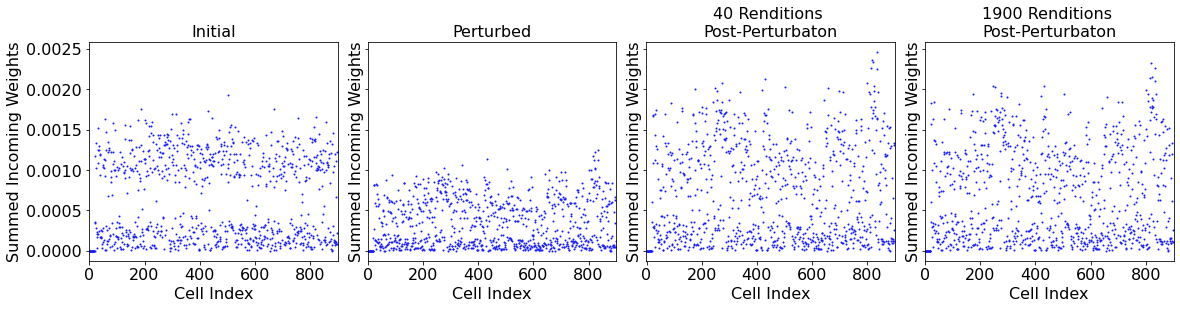

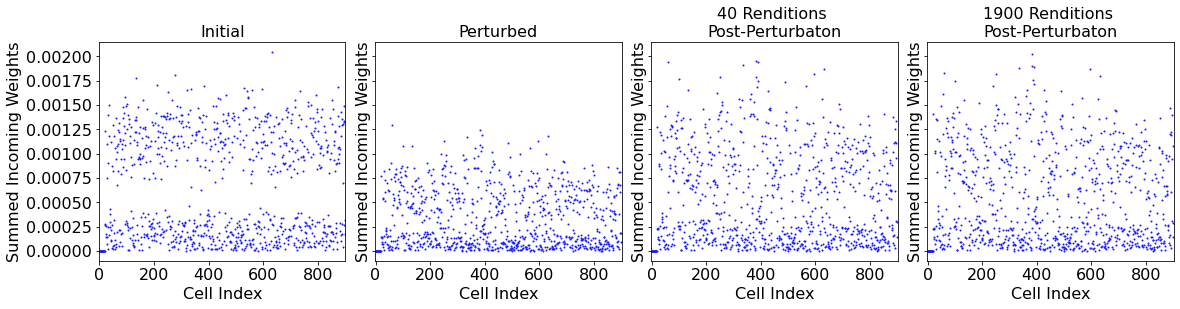

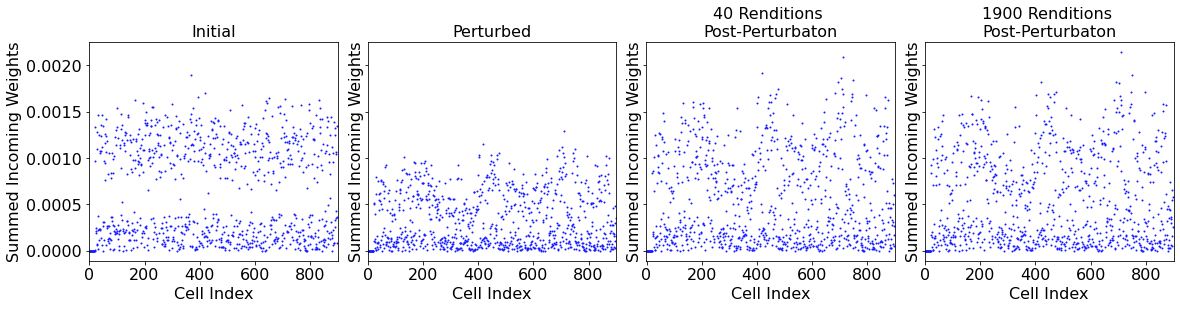

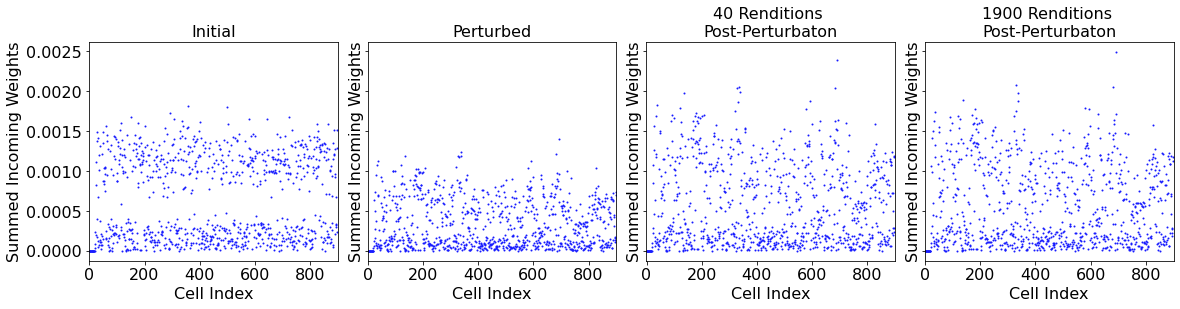

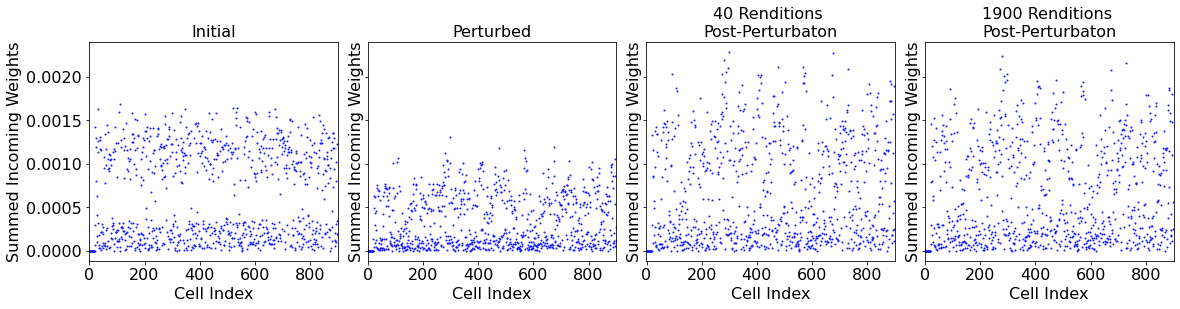

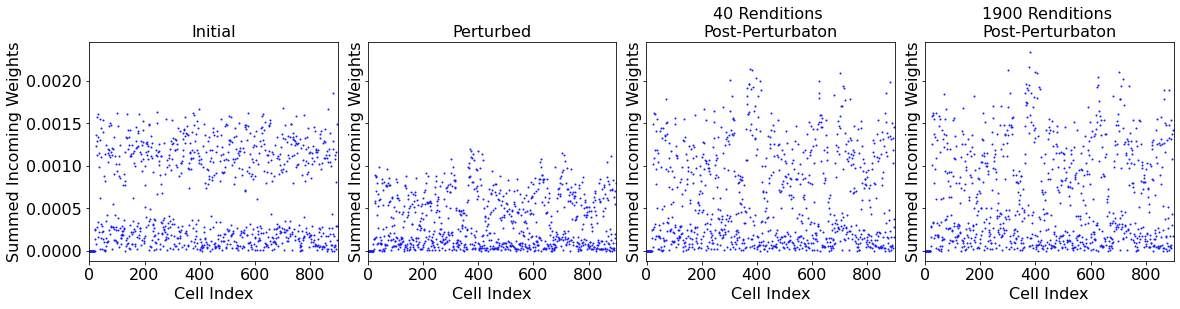

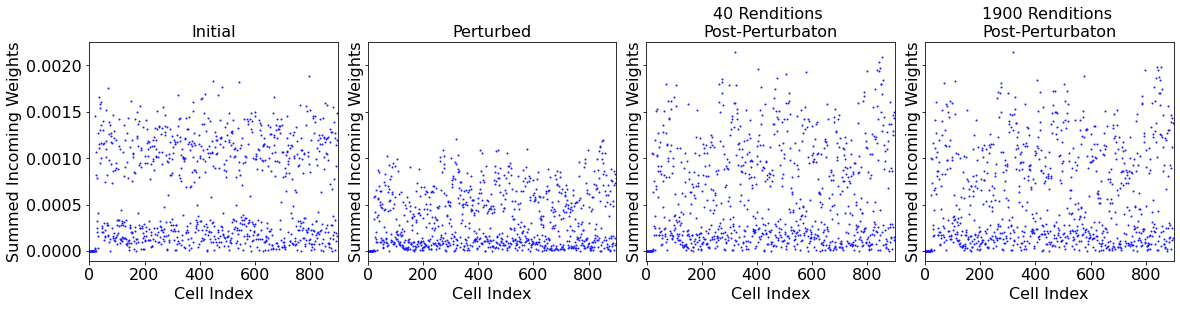

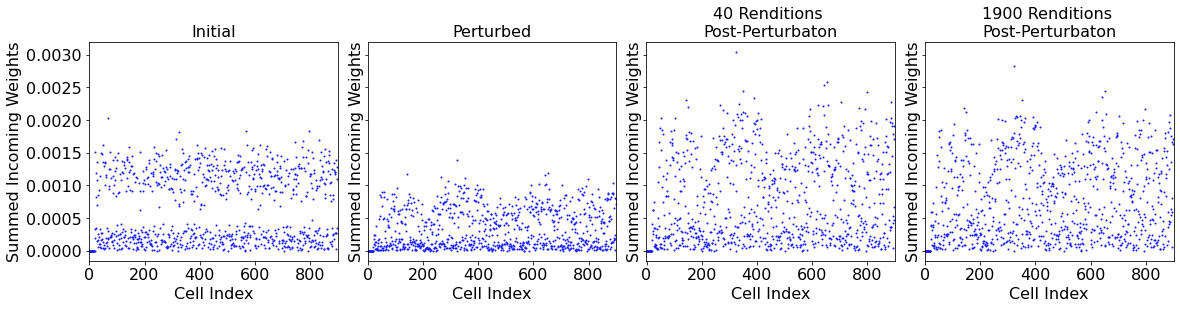

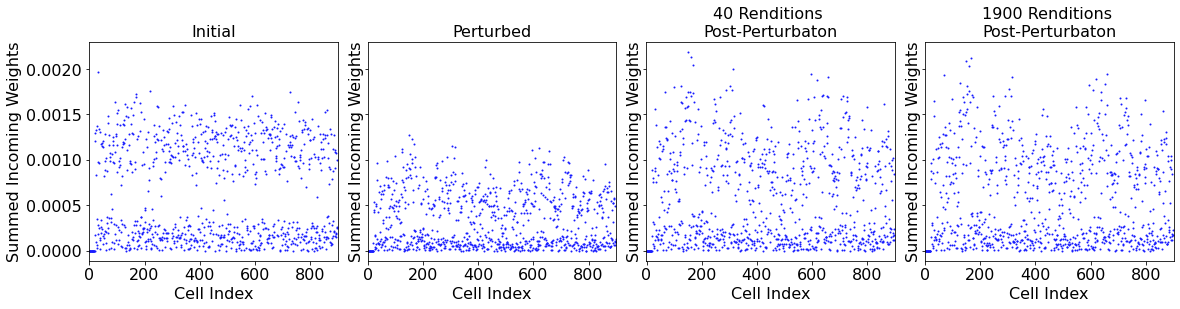

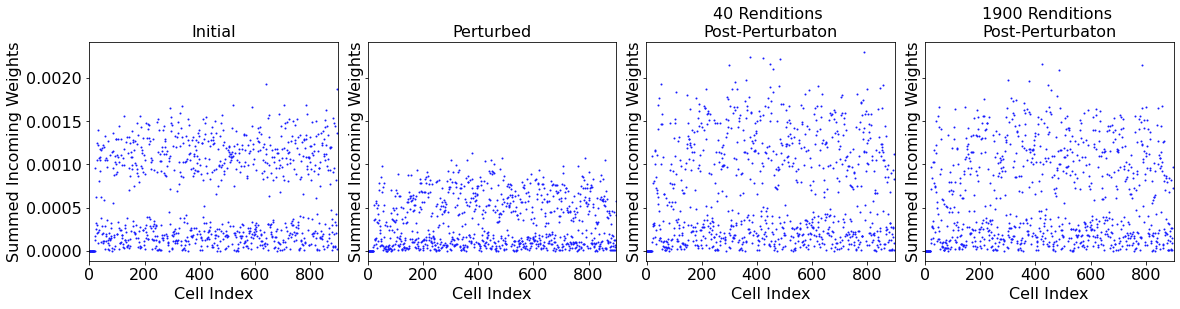

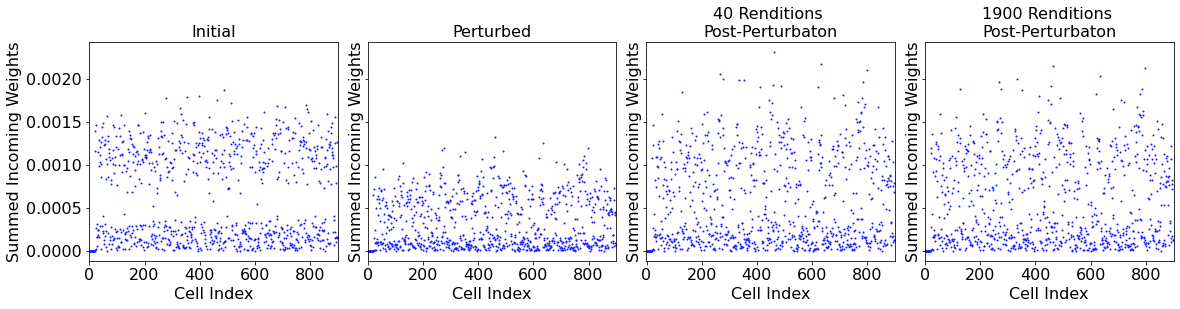

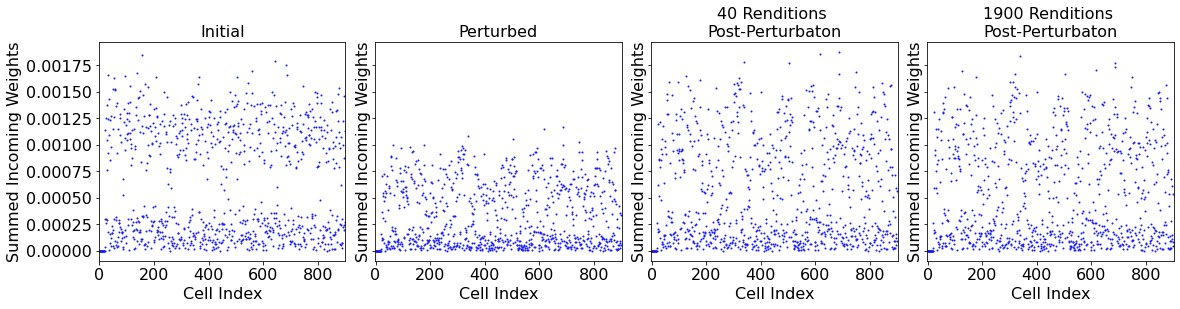

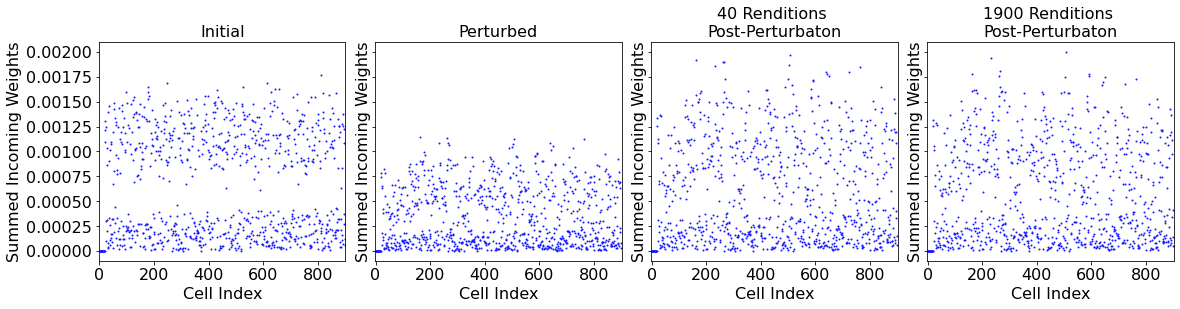

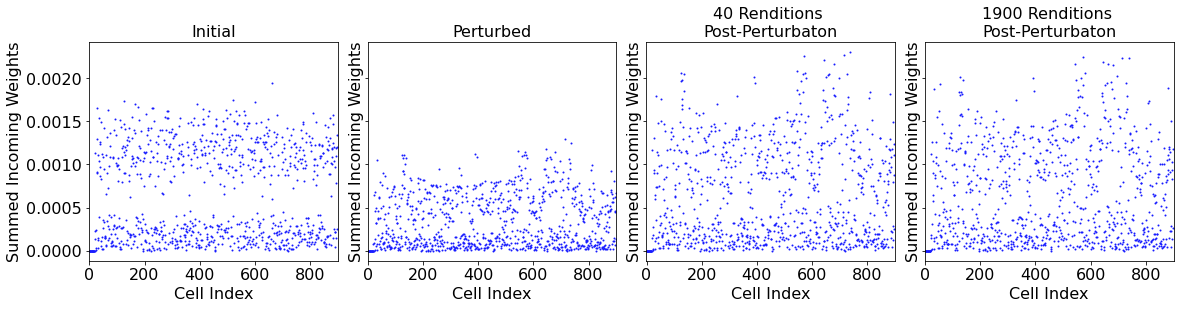

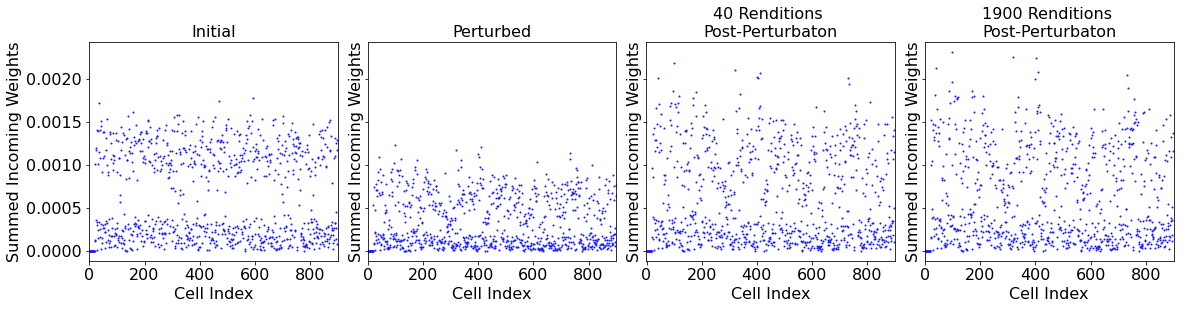

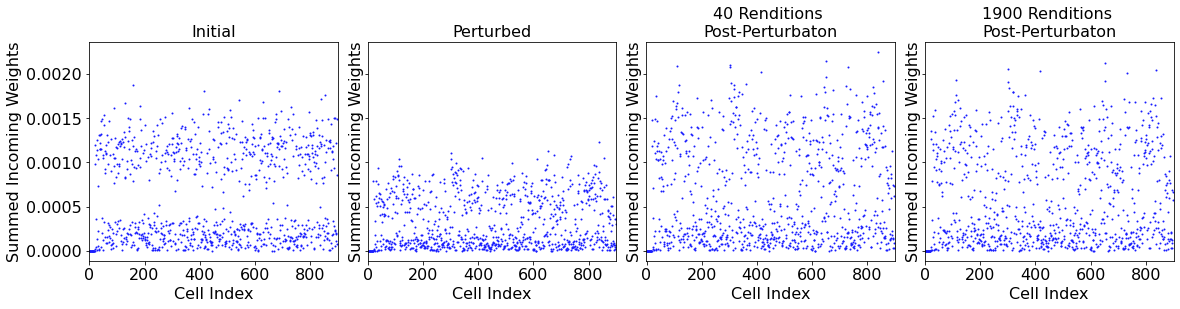

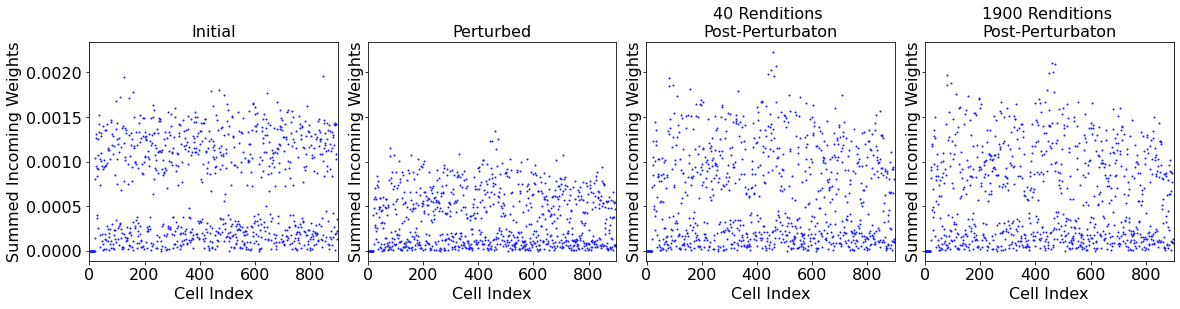

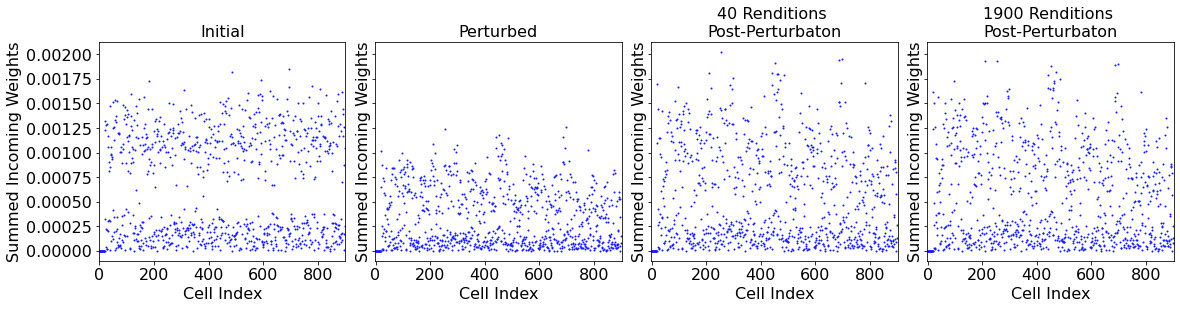

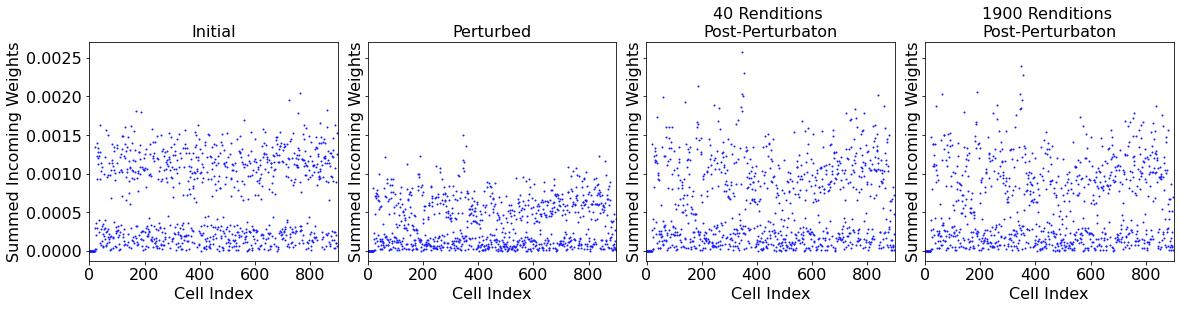

In [86]:
make_figure_5('pop', '#171bff')

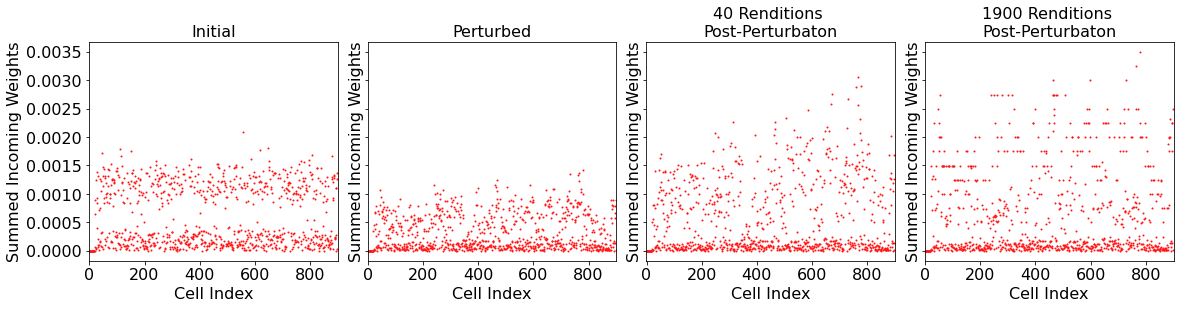

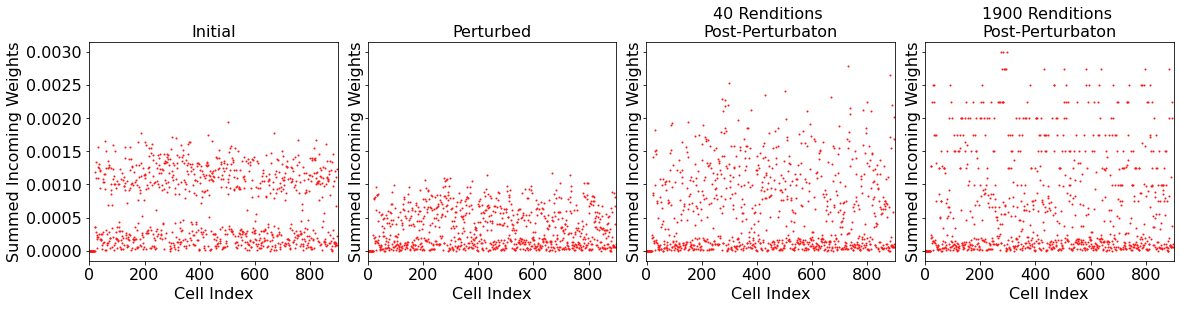

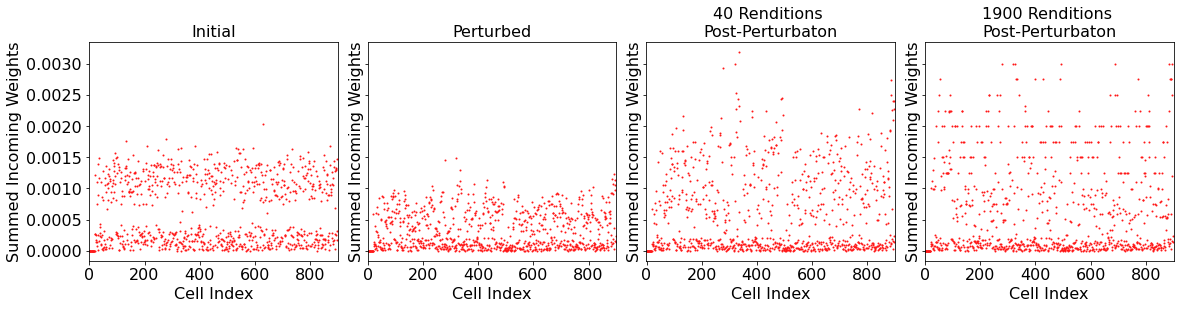

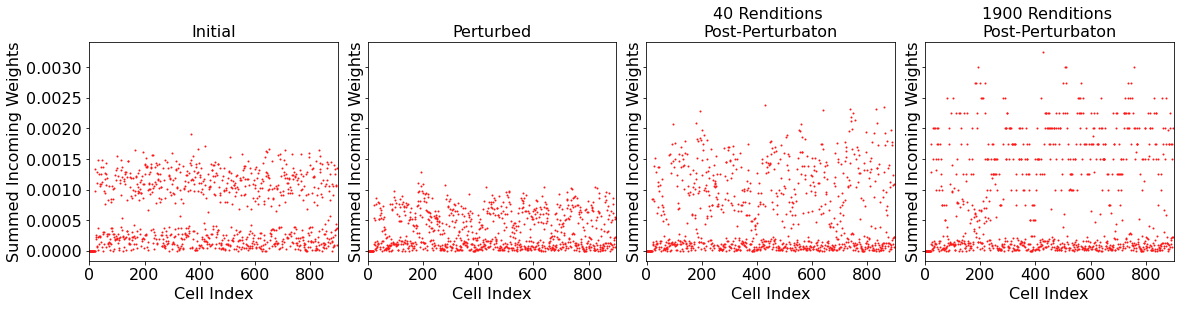

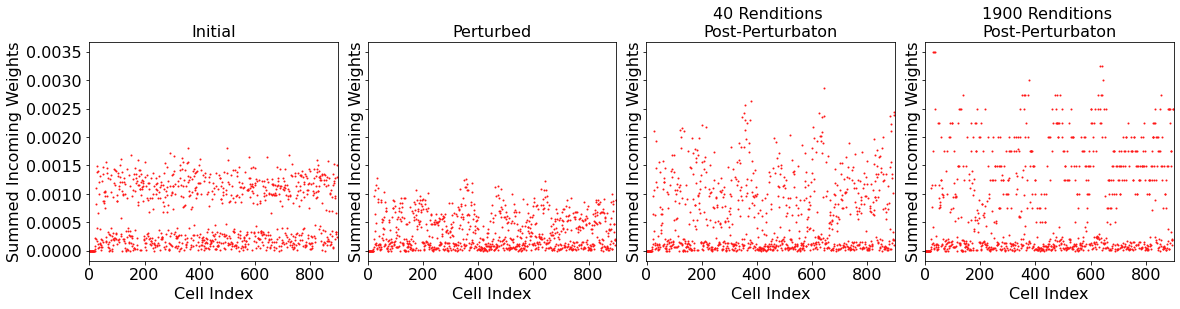

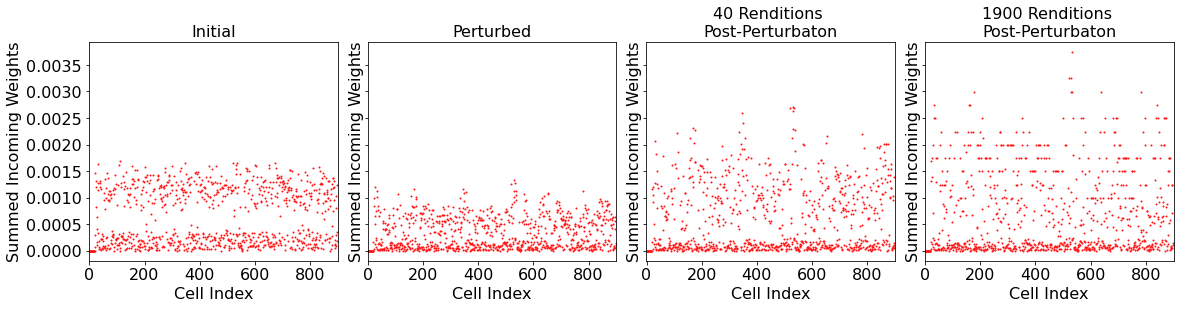

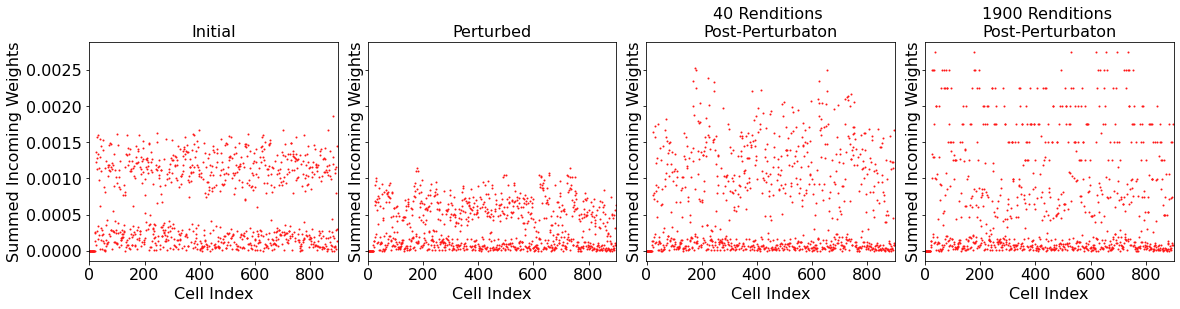

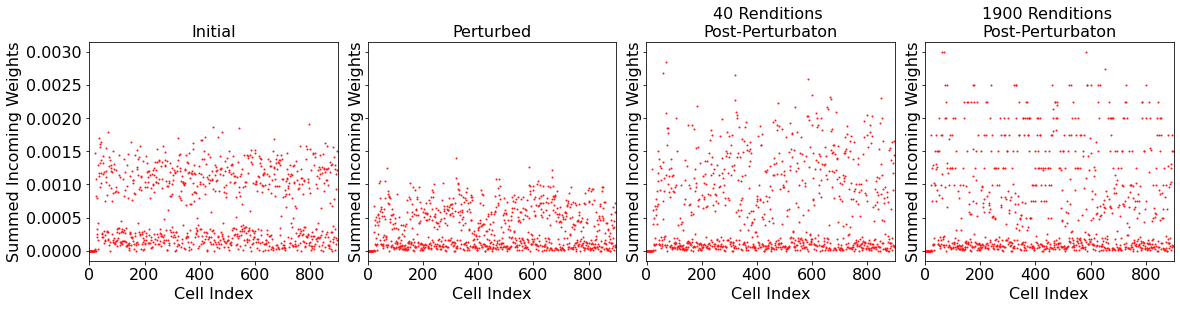

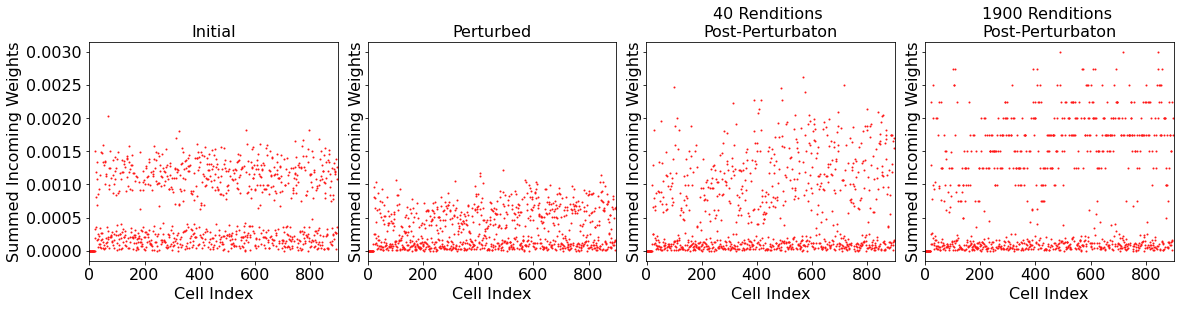

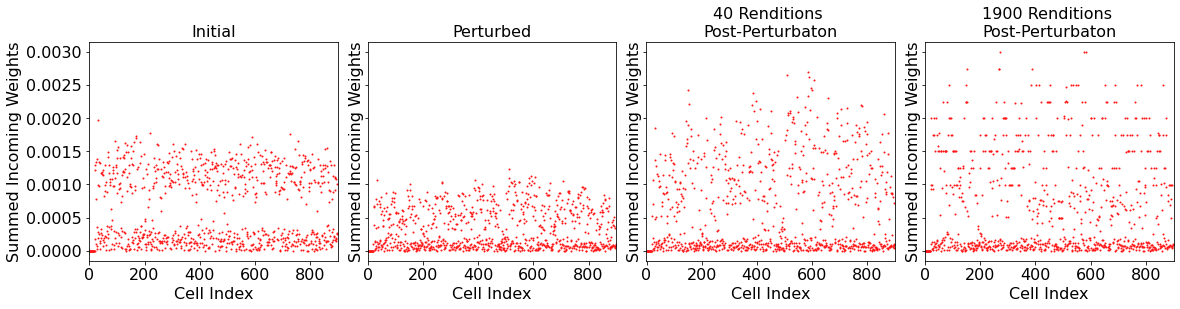

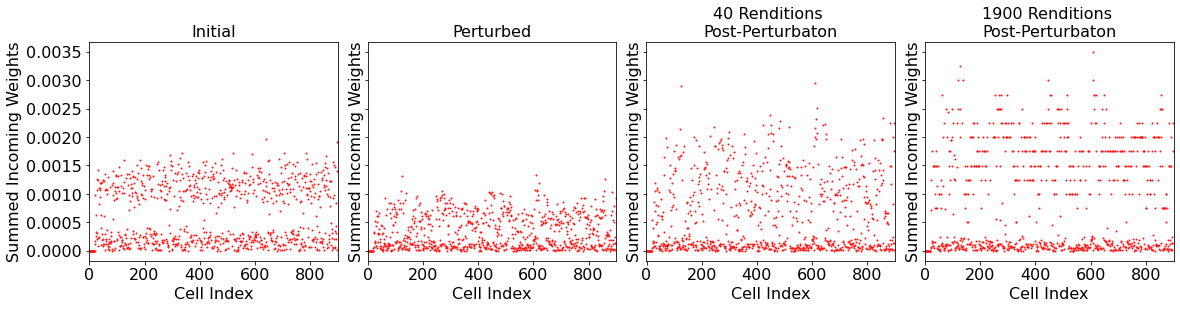

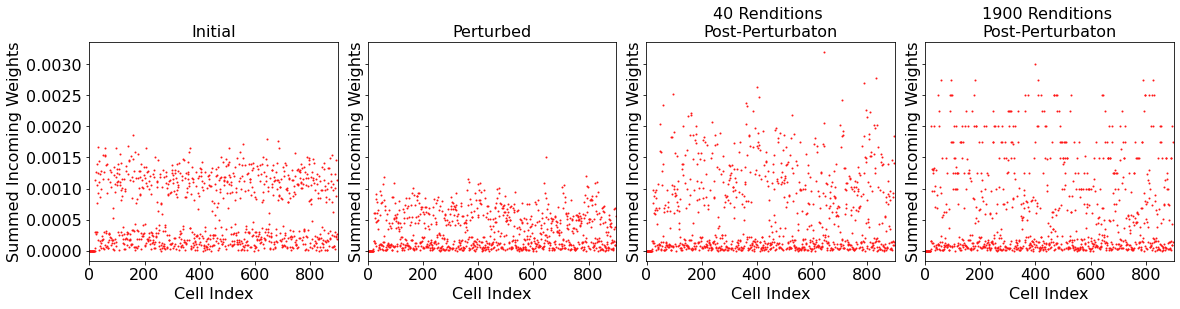

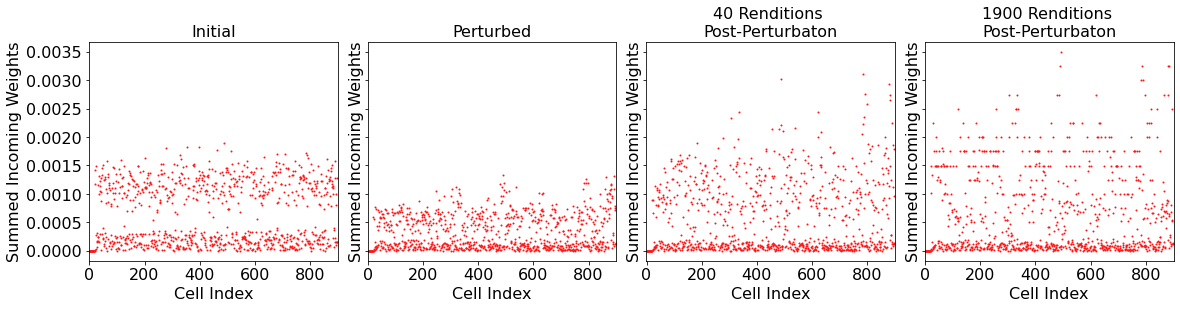

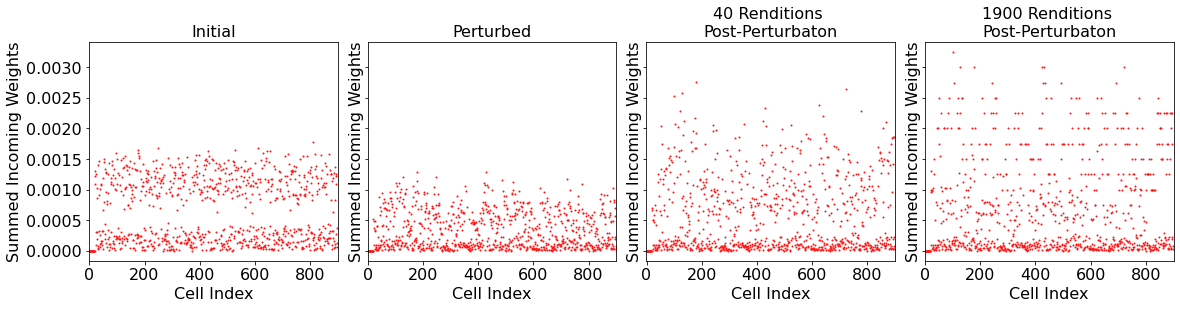

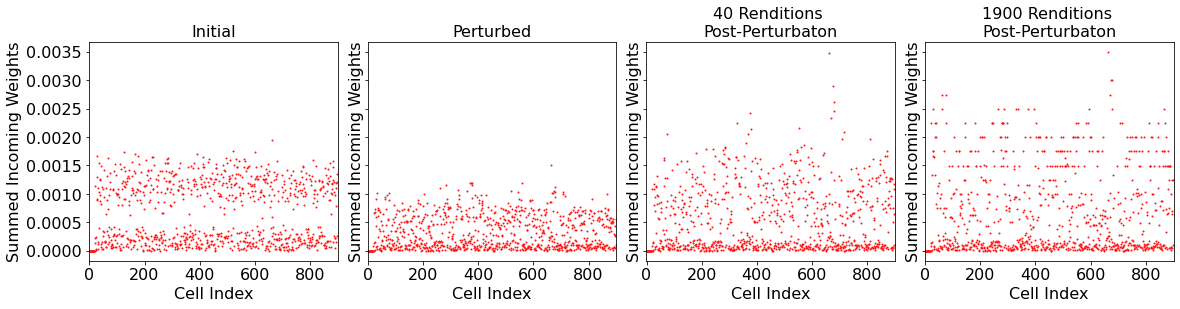

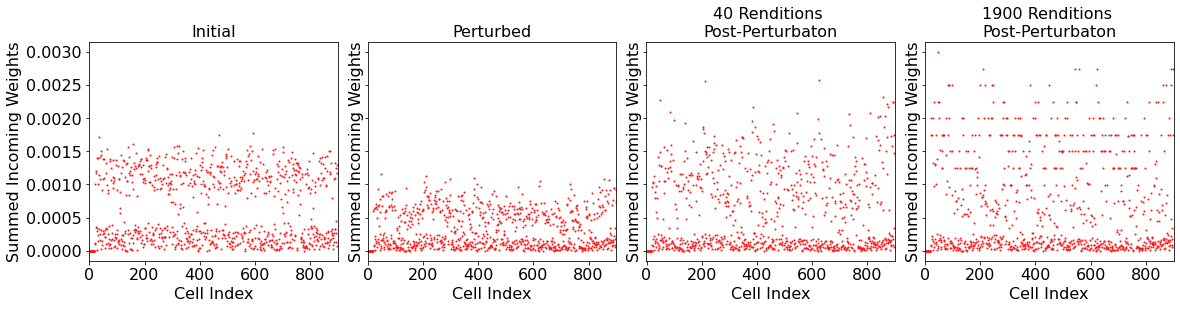

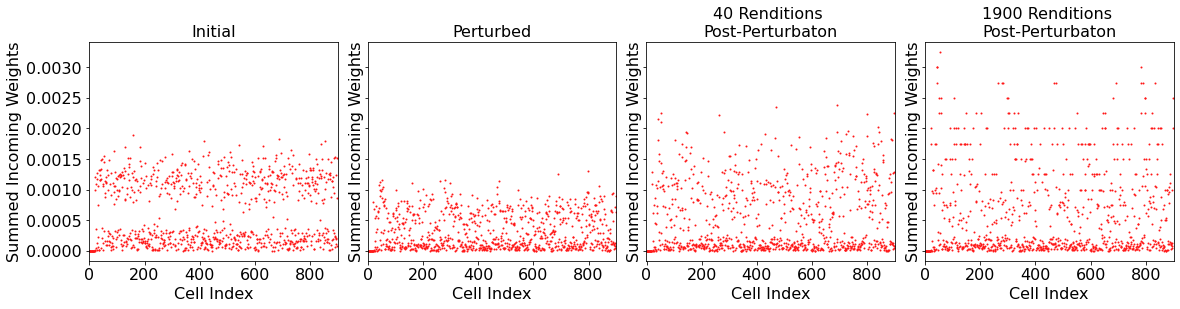

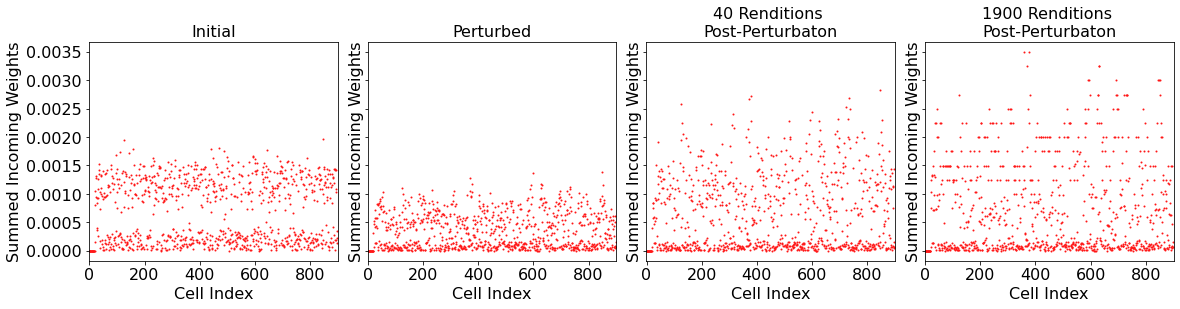

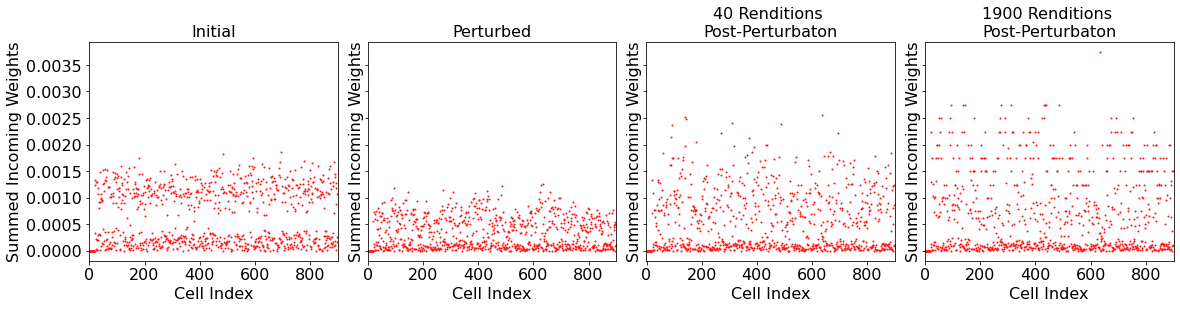

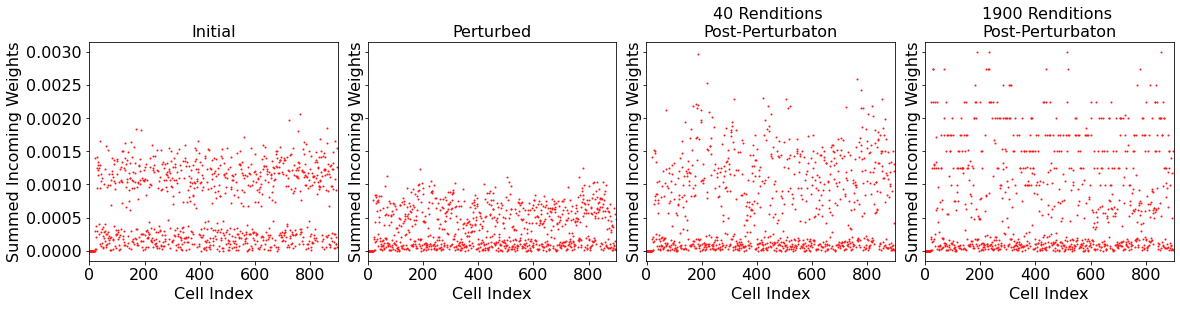

In [87]:
make_figure_5('single', '#ff1717')